**Q2: Using "corners_prices.csv", calculate the probability of the events happening (i.e. home most corners/away most corners/draw for 1X2, over/under the line for OU, home/away having most corners under the handicap line for HC).**

**a) How many selections are you betting? Why?**

**b) Calculate "EV" as the Expected Value of a bet**

Now look at "corners_prices_results.csv". This file contains the match results of the games in "corners_prices.csv".
c) Define "Stake" as the amount that you bet, calculate "PnL" as the Profit and Loss and "RoI" as PnL/Stake.

**C(i) Calculate the overall PnL and RoI**

**ii) Plot the cumulative PnL and EV as a function of time in days**

**iii) Plot the 2-week rolling PnL and EV average**

**d) Do you think that your assumed EV is an accurate representation of your real edge? (Hint: Run a Monte Carlo simulation)**

**Some Notes:**

These are bookmaker odds, so we remove clear outliers given theres always a spread. 

 We begin with preprocessing. Like Q1 with the corners_data, the data has a number of NANs and the timestamp for Hour-Minute-Second is missing from certain dates. The data is also unordered.

**I do Q2 twice. Once while utilising the point predictions from random forest, and again while using the probabilistic predictions from conformal prediction.**

*Scroll past the first attmept to find the attempt with Conformal Prediction*

**Data Quality Issues and Solution Approach**

*Key Problems Identified*

Feature Mismatch: Q1 dataset (corners_data.csv) has team_id, competition_id, season_id while Q2 dataset (corners_prices.csv) lacks these features. Cannot apply Q1 model to Q2 data.

Data Leakage: Using betting odds as features changes this from a prediction problem to a market efficiency analysis. Odds already incorporate all available information.

*Solution Approach*

Merge corners_prices.csv and corners_prices_results.csv on match_id

Use only matched records for complete analysis

Treat as unified modeling problem rather than forcing incompatible Q1→Q2 application

Apply walk-forward validation appropriate for time series betting data

Key observation:

The dataset contains only bookmaker odds, which inherently include built-in profit margins. In an efficient market, any genuinely positive expected value opportunities would be identified and eliminated almost immediately through market forces and arbitrage. The absence of positive EV selections in our analysis is therefore expected and reflects normal market conditions rather than a limitation of our modeling approach. Any positive EV opportunities that do appear in such datasets are typically the result of data errors, temporary pricing inefficiencies that last mere seconds, or edge cases that would be corrected before most bettors could act upon them.

To start, we load In relevant Libraries for data preprocessing - data cleaning, removing Nans, dealing with outliers, ordering the data, and engineering new features.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import math
from scipy import stats
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

Loading in the Data

In [ ]:
dat = pd.read_csv(r"C:\Users\ciara\OneDrive\Documents\White_Swan_Data\corners_prices.csv")
dat

Same as question 1, this block performs date-time formatting and basic data cleaning. It standardises the date_time column to a consistent YYYY-MM-DD HH:MM:SS format, filling in missing time components where necessary. It then converts the column to datetime, sorts the data chronologically by date_time and match_id, and identifies any remaining missing values across columns for inspection.

In [ ]:
old_dat=dat #For sense checks
DEFAULT_TIME = "12:00:00"
s = dat["date_time"].astype(str).str.strip()
s = s.str.replace("T", " ", regex=False).str.replace("/", "-", regex=False)
mask_date_only = s.str.match(r"^\d{4}-\d{2}-\d{2}$")
mask_no_seconds = s.str.match(r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$")
s.loc[mask_date_only] = s.loc[mask_date_only] + f" {DEFAULT_TIME}"
s.loc[mask_no_seconds] = s.loc[mask_no_seconds] + ":00"
dat["date_time"] = pd.to_datetime(s, errors="coerce")
dat = dat.sort_values(["date_time", "match_id"]).reset_index(drop=True)

nan_counts = dat.isna().sum() 
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False) 
print("Columns with missing values:\n") 
print(nan_counts)
dat

**Q2: Using "corners_prices.csv", calculate the probability of the events happening (i.e. home most corners/away most corners/draw for 1X2, over/under the line for OU, home/away having most corners under the handicap line for HC).**

Remove NaNs 

In [2]:
corners_prices = pd.read_csv(r"C:\Users\ciara\OneDrive\Documents\White_Swan_Data\corners_prices.csv")
corners_prices = corners_prices.dropna(subset=["oh", "oa", "od"])
nan_counts = corners_prices.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

Columns with missing values:

Series([], dtype: int64)


In [3]:
results = pd.read_csv(r"C:\Users\ciara\OneDrive\Documents\White_Swan_Data\corners_prices_results.csv")
results = results.dropna(subset=['home_corners', 'away_corners'])
nan_counts = results.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

Columns with missing values:

Series([], dtype: int64)


Merge datasets

In [4]:
# corners_prices = pd.read_csv(r"C:\Users\ciara\OneDrive\Documents\White_Swan_Data\corners_prices.csv")
# results = pd.read_csv(r"C:\Users\ciara\OneDrive\Documents\White_Swan_Data\corners_prices_results.csv")
dat1 = corners_prices
dat2 = results
ids_1 = set(dat1['match_id'].unique())
ids_2 = set(dat2['match_id'].unique())
common_ids = ids_1 & ids_2
only_in_dat1 = ids_1 - ids_2
only_in_dat2 = ids_2 - ids_1
print(f"Total unique match_id in dat1: {len(ids_1)}")
print(f"Total unique match_id in dat2: {len(ids_2)}")
print(f"Match IDs in both datasets: {len(common_ids)}")
filtered_prices = corners_prices[corners_prices["match_id"].isin(results["match_id"])]
reduced_prices = filtered_prices.groupby("match_id").first().reset_index()
# dat = pd.merge(results, reduced_prices, on="match_id", how="left")
dat = pd.merge(results, reduced_prices, on="match_id", how="inner")

dat

Total unique match_id in dat1: 1925
Total unique match_id in dat2: 2293
Match IDs in both datasets: 1922


,match_id,home_ft_score,away_ft_score,home_corners,away_corners,home_team_id,away_team_id,competition_id,season_id,date_time,gameweek,oh,oa,od,odds_type
0,12409670,0,2,4.0,5.0,1642,1669,364,189908,2025-05-01 18:30:00,34,1.73,2.38,8.0,1X2
1,12409748,1,2,2.0,3.0,1609,1659,364,189908,2025-05-03 16:30:00,35,1.43,3.20,9.0,1X2
2,12409691,1,0,5.0,3.0,1614,1616,364,189908,2025-05-03 11:30:00,35,1.92,1.90,-1.5,HC
3,12409683,4,3,7.0,3.0,1669,1611,364,189908,2025-05-04 13:00:00,35,1.82,1.98,10.5,OU
4,12409668,1,1,1.0,4.0,1651,1613,364,189908,2025-05-04 13:00:00,35,2.02,2.02,7.5,1X2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1917,12425794,1,3,3.0,3.0,3787,3799,412,189972,2025-01-12 16:15:00,17,2.02,1.78,9.5,OU
1918,12412160,1,3,2.0,3.0,684,696,795,189974,2025-01-18 17:30:00,20,1.40,3.40,8.8,1X2
1919,12412610,1,0,7.0,2.0,681,690,795,189974,2024-11-02 13:00:00,12,1.84,1.96,9.5,OU
1920,12412649,0,1,2.0,3.0,692,679,795,189974,2024-09-26 19:00:00,7,1.98,1.82,9.5,OU


Next we perform the preprocessing on the corners_prices_results

Outlier Analysis: This step focuses on identifying anomalies in the corner and goal data. We examine both missing values and statistical outliers using the Interquartile Range (IQR) and Z-score methods. The primary variables of interest are home/away goals and corners, including their totals and differences.

In [9]:
def analyze_outliers_extended(dat):
    corner_cols = ['home_corners', 'away_corners']
    goal_cols = ['home_ft_score', 'away_ft_score']
    print("=== COMPREHENSIVE OUTLIER ANALYSIS: CORNERS & GOALS ===\n")
    dat['total_corners'] = dat['home_corners'] + dat['away_corners']
    dat['total_goals'] = dat['home_ft_score'] + dat['away_ft_score']
    dat['corner_difference'] = dat['home_corners'] - dat['away_corners']
    dat['goal_difference'] = dat['home_ft_score'] - dat['away_ft_score']
    all_cols = {
        'Corners': ['home_corners', 'away_corners', 'total_corners', 'corner_difference'],
        'Goals': ['home_ft_score', 'away_ft_score', 'total_goals', 'goal_difference']
    }
    print("1. BASIC STATISTICS:")
    print("CORNERS:")
    print(dat[all_cols['Corners']].describe())
    print("\nGOALS:")
    print(dat[all_cols['Goals']].describe())
    print("\n" + "="*60 + "\n")
    print("2. IQR METHOD OUTLIERS:")
    outlier_summary = {}
    for category, cols in all_cols.items():
        print(f"{category.upper()}:")
        for col in cols:
            Q1 = dat[col].quantile(0.25)
            Q3 = dat[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = dat[(dat[col] < lower_bound) | (dat[col] > upper_bound)]
            outlier_summary[col] = {
                'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
                'lower_bound': lower_bound, 'upper_bound': upper_bound,
                'outlier_count': len(outliers),
                'outlier_percentage': len(outliers) / len(dat) * 100
            }
            
            print(f"  {col}:")
            print(f"    Bounds: [{lower_bound:.1f}, {upper_bound:.1f}]")
            print(f"    Outliers: {len(outliers)} ({len(outliers)/len(dat)*100:.2f}%)")
            if len(outliers) > 0:
                print(f"    Outlier values: {sorted(outliers[col].unique())}")
            print()
        print()
    print("3. Z-SCORE METHOD (|z| > 3):")
    for category, cols in all_cols.items():
        print(f"{category.upper()}:")
        for col in cols:
            z_scores = np.abs((dat[col] - dat[col].mean()) / dat[col].std())
            z_outliers = dat[z_scores > 3]
            print(f"  {col}: {len(z_outliers)} outliers ({len(z_outliers)/len(dat)*100:.2f}%)")
            if len(z_outliers) > 0:
                print(f"    Values: {sorted(z_outliers[col].unique())}")
            print()
        print()
    print("4. EXTREME VALUES:")
    for category, cols in all_cols.items():
        print(f"{category.upper()}:")
        for col in cols:
            print(f"  {col}:")
            print(f"    Maximum: {dat[col].max()}")
            print(f"    Top 5 values: {sorted(dat[col].unique())[-5:]}")
            print(f"    Minimum: {dat[col].min()}")
            print(f"    Bottom 5 values: {sorted(dat[col].unique())[:5]}")
            print()
        print()
    print("5. SAMPLE OF EXTREME MATCHES:")
    print("HIGHEST CORNER MATCHES (99th percentile):")
    high_corner_matches = dat[dat['total_corners'] >= dat['total_corners'].quantile(0.99)]
    print(high_corner_matches[['match_id', 'date_time', 'home_corners', 'away_corners', 'total_corners', 'home_ft_score', 'away_ft_score', 'total_goals']].head(10))
    print("\nLOWEST CORNER MATCHES (1st percentile):")
    low_corner_matches = dat[dat['total_corners'] <= dat['total_corners'].quantile(0.01)]
    print(low_corner_matches[['match_id', 'date_time', 'home_corners', 'away_corners', 'total_corners', 'home_ft_score', 'away_ft_score', 'total_goals']].head(10))
    print("\nHI-GHEST SCORING MATCHES (99th percentile):")
    high_goal_matches = dat[dat['total_goals'] >= dat['total_goals'].quantile(0.99)]
    print(high_goal_matches[['match_id', 'date_time', 'home_ft_score', 'away_ft_score', 'total_goals', 'home_corners', 'away_corners', 'total_corners']].head(10))
    print("\nLOWEST SCORING MATCHES (goalless draws):")
    low_goal_matches = dat[(dat['home_ft_score'] == 0) & (dat['away_ft_score'] == 0)]
    print(f"Total goalless draws: {len(low_goal_matches)}")
    print(low_goal_matches[['match_id', 'date_time', 'home_ft_score', 'away_ft_score', 'total_goals', 'home_corners', 'away_corners', 'total_corners']].head(10))
    print("\n6. CORNER-GOAL RELATIONSHIP OUTLIERS:")
    high_corners_low_goals = dat[(dat['total_corners'] >= dat['total_corners'].quantile(0.9)) & 
                               (dat['total_goals'] <= dat['total_goals'].quantile(0.3))]
    print(f"\nHigh corners (90th+ percentile) but low goals (30th- percentile): {len(high_corners_low_goals)} matches")
    if len(high_corners_low_goals) > 0:
        print(high_corners_low_goals[['match_id', 'date_time', 'home_corners', 'away_corners', 'total_corners', 'home_ft_score', 'away_ft_score', 'total_goals']].head())
    low_corners_high_goals = dat[(dat['total_corners'] <= dat['total_corners'].quantile(0.3)) & 
                               (dat['total_goals'] >= dat['total_goals'].quantile(0.9))]
    print(f"\nLow corners (30th- percentile) but high goals (90th+ percentile): {len(low_corners_high_goals)} matches")
    if len(low_corners_high_goals) > 0:
        print(low_corners_high_goals[['match_id', 'date_time', 'home_corners', 'away_corners', 'total_corners', 'home_ft_score', 'away_ft_score', 'total_goals']].head())
    print("\n7. OUTLIER SUMMARY:")
    print("IQR Method Outlier Percentages:")
    for col, info in outlier_summary.items():
        print(f"  {col}: {info['outlier_percentage']:.2f}% ({info['outlier_count']} matches)")
    
    return outlier_summary
outlier_info = analyze_outliers_extended(dat)

=== COMPREHENSIVE OUTLIER ANALYSIS: CORNERS & GOALS ===

1. BASIC STATISTICS:
CORNERS:
       home_corners  away_corners  total_corners  corner_difference
count   1922.000000   1922.000000    1922.000000        1922.000000
mean       5.301249      4.373049       9.674298           0.928200
std        3.002738      2.609549       3.363313           4.510044
min        0.000000      0.000000       1.000000         -14.000000
25%        3.000000      2.000000       7.000000          -2.000000
50%        5.000000      4.000000      10.000000           1.000000
75%        7.000000      6.000000      12.000000           4.000000
max       18.000000     16.000000      23.000000          17.000000

GOALS:
       home_ft_score  away_ft_score  total_goals  goal_difference
count    1922.000000    1922.000000  1922.000000      1922.000000
mean        1.486472       1.274194     2.760666         0.212279
std         1.273227       1.150900     1.639871         1.789464
min         0.000000       0.

We further inspect corner-related anomalies by examining unusually high corner-to-goal ratios. These checks help flag matches where corner activity appears disproportionate to goal output, possibly indicating noise or stylistic extremes.

In [10]:
def check_contextual_outliers(df):
    print("6. CONTEXTUAL OUTLIER CHECKS:")
    df['corner_to_goal_ratio_home'] = df['home_corners'] / (df['home_ft_score'] + 1)  # +1 to avoid division by zero
    df['corner_to_goal_ratio_away'] = df['away_corners'] / (df['away_ft_score'] + 1)
    high_ratio_home = df[df['corner_to_goal_ratio_home'] > 10]
    high_ratio_away = df[df['corner_to_goal_ratio_away'] > 10]
    print(f"Matches with very high home corner-to-goal ratio (>10): {len(high_ratio_home)}")
    print(f"Matches with very high away corner-to-goal ratio (>10): {len(high_ratio_away)}")
    negative_corners = df[(df['home_corners'] < 0) | (df['away_corners'] < 0)]
    print(f"Matches with negative corners: {len(negative_corners)}")
    zero_corners = df[(df['home_corners'] == 0) & (df['away_corners'] == 0)]
    print(f"Matches with 0 total corners: {len(zero_corners)}")
    return high_ratio_home, high_ratio_away, negative_corners, zero_corners

contextual_outliers = check_contextual_outliers(dat)

6. CONTEXTUAL OUTLIER CHECKS:
Matches with very high home corner-to-goal ratio (>10): 27
Matches with very high away corner-to-goal ratio (>10): 14
Matches with negative corners: 0
Matches with 0 total corners: 0


 same as Q1. This step consolidates all cleaning processes — removing invalid entries (e.g., 999s), rounding fractional values, flagging implausible outliers, and imputing missing data using competition and season averages.

In [13]:
def data_cleaning(df):    
    df_clean = df.copy()
    cleaning_log = []
    print("1. CLEANING 999 VALUES:")
    mask_999 = (df_clean['home_corners'] == 999) | (df_clean['away_corners'] == 999)
    count_999 = mask_999.sum()
    df_clean.loc[mask_999, ['home_corners', 'away_corners']] = np.nan
    print(f"   Replaced {count_999} matches with 999 values -> NaN")
    cleaning_log.append(f"999 values: {count_999} matches")
    print("\n2. CLEANING FRACTIONAL VALUES:")
    home_fractional = df_clean['home_corners'].notna() & (df_clean['home_corners'] % 1 != 0)
    away_fractional = df_clean['away_corners'].notna() & (df_clean['away_corners'] % 1 != 0)
    count_home_frac = home_fractional.sum()
    count_away_frac = away_fractional.sum()
    print(f"   Found {count_home_frac} fractional home corner values")
    print(f"   Found {count_away_frac} fractional away corner values")
    if count_home_frac > 0:
        print("   Fractional home values:", df_clean.loc[home_fractional, 'home_corners'].values)
    if count_away_frac > 0:
        print("   Fractional away values:", df_clean.loc[away_fractional, 'away_corners'].values)
    df_clean.loc[home_fractional, 'home_corners'] = df_clean.loc[home_fractional, 'home_corners'].round()
    df_clean.loc[away_fractional, 'away_corners'] = df_clean.loc[away_fractional, 'away_corners'].round()
    cleaning_log.append(f"Fractional values: {count_home_frac + count_away_frac} values rounded")
    print("\n3. CHECKING FOR NEGATIVE VALUES:")
    negative_home = (df_clean['home_corners'] < 0).sum()
    negative_away = (df_clean['away_corners'] < 0).sum()
    print(f"   Negative home corners: {negative_home}")
    print(f"   Negative away corners: {negative_away}")
    if negative_home > 0 or negative_away > 0:
        df_clean.loc[df_clean['home_corners'] < 0, 'home_corners'] = np.nan
        df_clean.loc[df_clean['away_corners'] < 0, 'away_corners'] = np.nan
        cleaning_log.append(f"Negative values: {negative_home + negative_away} values set to NaN")
    print("\n4. CHECKING FOR EXTREMELY HIGH VALUES:")
    high_home = (df_clean['home_corners'] > 25).sum()
    high_away = (df_clean['away_corners'] > 25).sum()
    print(f"   Home corners >25: {high_home}")
    print(f"   Away corners >25: {high_away}")
    if high_home > 0:
        extreme_home = df_clean[df_clean['home_corners'] > 25]
        print("   Extreme home values:", extreme_home[['match_id', 'home_corners', 'away_corners']].values)
    if high_away > 0:
        extreme_away = df_clean[df_clean['away_corners'] > 25]
        print("   Extreme away values:", extreme_away[['match_id', 'home_corners', 'away_corners']].values)
    print("\n5. MISSING DATA SUMMARY:")
    total_missing_home = df_clean['home_corners'].isna().sum()
    total_missing_away = df_clean['away_corners'].isna().sum()
    total_missing_either = (df_clean['home_corners'].isna() | df_clean['away_corners'].isna()).sum()
    print(f"   Missing home corners: {total_missing_home}")
    print(f"   Missing away corners: {total_missing_away}")
    print(f"   Matches missing either corner data: {total_missing_either}")
    print("\n6. CREATING CLEAN DATASETS:")
    df_complete_cases = df_clean.dropna(subset=['home_corners', 'away_corners']).copy()
    df_imputed = df_clean.copy()
    if 'competition_id' in df_imputed.columns and 'season_id' in df_imputed.columns:
        home_means = df_imputed.groupby(['competition_id', 'season_id'])['home_corners'].transform('mean')
        away_means = df_imputed.groupby(['competition_id', 'season_id'])['away_corners'].transform('mean')
        df_imputed['home_corners'] = df_imputed['home_corners'].fillna(home_means)
        df_imputed['away_corners'] = df_imputed['away_corners'].fillna(away_means)
        df_imputed['home_corners'] = df_imputed['home_corners'].fillna(df_imputed['home_corners'].mean())
        df_imputed['away_corners'] = df_imputed['away_corners'].fillna(df_imputed['away_corners'].mean())
        print(f"   Used competition/season-based imputation")
    else:
        df_imputed['home_corners'] = df_imputed['home_corners'].fillna(df_imputed['home_corners'].mean())
        df_imputed['away_corners'] = df_imputed['away_corners'].fillna(df_imputed['away_corners'].mean())
        print(f"   Used overall mean imputation")
    df_imputed['home_corners'] = df_imputed['home_corners'].round()
    df_imputed['away_corners'] = df_imputed['away_corners'].round()
    print(f"   Complete cases dataset: {len(df_complete_cases)} matches")
    print(f"   Imputed dataset: {len(df_imputed)} matches")
    print(f"   Original dataset: {len(df)} matches")
    print("\n7. FINAL CLEANED DATA STATISTICS:")
    print("\nComplete Cases Dataset:")
    print(df_complete_cases[['home_corners', 'away_corners']].describe())
    print("\nImputed Dataset:")
    print(df_imputed[['home_corners', 'away_corners']].describe())
    print(f"\n8. DATA CLEANING SUMMARY:")
    print(f"   Original matches: {len(df)}")
    for log_entry in cleaning_log:
        print(f"   - {log_entry}")
    print(f"   Final complete cases: {len(df_complete_cases)} ({len(df_complete_cases)/len(df)*100:.1f}%)")
    print(f"   Data loss: {len(df) - len(df_complete_cases)} matches ({(len(df) - len(df_complete_cases))/len(df)*100:.1f}%)")
    return df_complete_cases, df_imputed, cleaning_log

#We validate the cleaned dataset by confirming there are no missing, fractional, or negative values, 
#and that the statistical ranges for corners remain reasonable.
def validate_cleaned_data(df):    
    print(f"Home corners range: {df['home_corners'].min():.0f} - {df['home_corners'].max():.0f}")
    print(f"Away corners range: {df['away_corners'].min():.0f} - {df['away_corners'].max():.0f}")
    print(f"Any NaN values: {df[['home_corners', 'away_corners']].isna().sum().sum()}")
    print(f"Any non-integer values: {((df['home_corners'] % 1 != 0) | (df['away_corners'] % 1 != 0)).sum()}")
    print(f"Any negative values: {((df['home_corners'] < 0) | (df['away_corners'] < 0)).sum()}")
    df['total_corners'] = df['home_corners'] + df['away_corners']
    print(f"Matches: {len(df)}")
    print(f"Mean corners: {df['home_corners'].mean():.2f} home, {df['away_corners'].mean():.2f} away")
    print(f"Total corners range: {df['total_corners'].min():.0f} - {df['total_corners'].max():.0f}")
    return df
df_clean, df_imputed, log = data_cleaning(dat)
dat = validate_cleaned_data(df_clean)  # we just want the cleaned data. Imputed isnt massively beneficial.
dat=dat.dropna()

1. CLEANING 999 VALUES:
   Replaced 0 matches with 999 values -> NaN

2. CLEANING FRACTIONAL VALUES:
   Found 0 fractional home corner values
   Found 0 fractional away corner values

3. CHECKING FOR NEGATIVE VALUES:
   Negative home corners: 0
   Negative away corners: 0

4. CHECKING FOR EXTREMELY HIGH VALUES:
   Home corners >25: 0
   Away corners >25: 0

5. MISSING DATA SUMMARY:
   Missing home corners: 0
   Missing away corners: 0
   Matches missing either corner data: 0

6. CREATING CLEAN DATASETS:
   Used competition/season-based imputation
   Complete cases dataset: 1922 matches
   Imputed dataset: 1922 matches
   Original dataset: 1922 matches

7. FINAL CLEANED DATA STATISTICS:

Complete Cases Dataset:
       home_corners  away_corners
count   1922.000000   1922.000000
mean       5.301249      4.373049
std        3.002738      2.609549
min        0.000000      0.000000
25%        3.000000      2.000000
50%        5.000000      4.000000
75%        7.000000      6.000000
max     

First Lets Focus on the New Features. In this transformation pipeline, we engineered a set of features to capture historical team performance, match dynamics, and contextual timing information. These include rolling means and exponentially weighted averages of corners and goals over the past five matches, both for teams playing at home and away. We added head-to-head corner averages, rest day differentials, cyclical encodings for weekday, kickoff time, and gameweek, as well as broader team form features aggregating recent performance regardless of home or away status. 
Additional metrics like corner win streaks, corner trend deltas, and normalized league-season corner z-scores provide contextual depth useful for model training. 

To avoid data leakage and maintain a clean dataset, we dropped all outcome-related columns such as full-time scores, total goals and corners, and derived statistics like goal or corner differences and ratios. We also removed intermediate columns used during feature generation like pair_key, match_total_corners, and previous match timestamps, as well as raw weekday and hour columns after encoding them sinusoidally. This ensures the final dataset contains only features available prior to the match and no labels or post-match outcomes.

In [14]:
old_dat=dat #For sense checks
N = 5
DEFAULT_TIME = "12:00:00"
s = dat["date_time"].astype(str).str.strip()
s = s.str.replace("T", " ", regex=False).str.replace("/", "-", regex=False)
mask_date_only = s.str.match(r"^\d{4}-\d{2}-\d{2}$")
mask_no_seconds = s.str.match(r"^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$")
s.loc[mask_date_only] = s.loc[mask_date_only] + f" {DEFAULT_TIME}"
s.loc[mask_no_seconds] = s.loc[mask_no_seconds] + ":00"
dat["date_time"] = pd.to_datetime(s, errors="coerce")
dat = dat.sort_values(["date_time", "match_id"]).reset_index(drop=True)
dat["home_corners_mean_5"] = dat.groupby("home_team_id")["home_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["home_goals_mean_5"] = dat.groupby("home_team_id")["home_ft_score"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["home_corners_conceded_mean_5"] = dat.groupby("home_team_id")["away_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["away_corners_mean_5"] = dat.groupby("away_team_id")["away_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["away_goals_mean_5"] = dat.groupby("away_team_id")["away_ft_score"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["away_corners_conceded_mean_5"] = dat.groupby("away_team_id")["home_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["home_corners_ewm_5"] = dat.groupby("home_team_id")["home_corners"].transform(lambda s: s.shift().ewm(span=N, adjust=False).mean())
dat["away_corners_ewm_5"] = dat.groupby("away_team_id")["away_corners"].transform(lambda s: s.shift().ewm(span=N, adjust=False).mean())
dat["pair_key"] = dat.apply(lambda r: f"{min(r.home_team_id, r.away_team_id)}_{max(r.home_team_id, r.away_team_id)}", axis=1)
dat["match_total_corners"] = dat["home_corners"] + dat["away_corners"]
dat["h2h_corners_mean_5"] = dat.groupby("pair_key")["match_total_corners"].transform(lambda s: s.shift().rolling(N, 1).mean())
dat["expected_corner_diff_form"] = dat["home_corners_mean_5"] - dat["away_corners_conceded_mean_5"]
dat["expected_corner_ratio_form"] = dat["home_corners_mean_5"] / (dat["away_corners_conceded_mean_5"] + 1e-6)
dat["home_prev_dt"] = dat.groupby("home_team_id")["date_time"].shift()
dat["away_prev_dt"] = dat.groupby("away_team_id")["date_time"].shift()
dat["home_rest_days"] = (dat["date_time"] - dat["home_prev_dt"]).dt.days
dat["away_rest_days"] = (dat["date_time"] - dat["away_prev_dt"]).dt.days
dat["rest_days_diff"] = dat["home_rest_days"] - dat["away_rest_days"]
dat["dow"] = dat["date_time"].dt.weekday
dat["dow_sin"] = np.sin(2 * np.pi * dat["dow"] / 7)
dat["dow_cos"] = np.cos(2 * np.pi * dat["dow"] / 7)
dat["gw_sin"] = np.sin(2 * np.pi * dat["gameweek"] / 38)
dat["gw_cos"] = np.cos(2 * np.pi * dat["gameweek"] / 38)
dat["ko_hour"] = dat["date_time"].dt.hour + dat["date_time"].dt.minute / 60
dat["ko_sin"] = np.sin(2 * np.pi * dat["ko_hour"] / 24)
dat["ko_cos"] = np.cos(2 * np.pi * dat["ko_hour"] / 24)
long_df = pd.concat([dat[["date_time", "home_team_id", "home_corners", "away_corners"]].rename(columns={"home_team_id": "team_id", "home_corners": "corners_for",
        "away_corners": "corners_against"}),
    dat[["date_time", "away_team_id", "away_corners", "home_corners"]].rename(columns={"away_team_id": "team_id", "away_corners": "corners_for",
        "home_corners": "corners_against"})])
long_df = long_df.sort_values(["team_id", "date_time"])
long_df["rolling_corners_mean_5"] = long_df.groupby("team_id")["corners_for"].transform(lambda s: s.shift().rolling(N, 1).mean())
long_df["rolling_corners_std_5"] = long_df.groupby("team_id")["corners_for"].transform(lambda s: s.shift().rolling(N, 1).std())
long_df["corner_trend_5"] = long_df.groupby("team_id")["corners_for"].transform(lambda s: s.shift().rolling(N, 2).mean().diff())
dat = dat.merge(long_df[["team_id", "date_time", "rolling_corners_mean_5", "rolling_corners_std_5", "corner_trend_5"]], left_on=["home_team_id", "date_time"], right_on=["team_id", "date_time"], how="left"
).rename(columns={"rolling_corners_mean_5": "home_form_mean_corners", "rolling_corners_std_5": "home_form_std_corners", "corner_trend_5": "home_corner_trend"}).drop(columns=["team_id"])
dat = dat.merge(long_df[["team_id", "date_time", "rolling_corners_mean_5", "rolling_corners_std_5", "corner_trend_5"]], left_on=["away_team_id", "date_time"], right_on=["team_id", "date_time"], how="left"
).rename(columns={"rolling_corners_mean_5": "away_form_mean_corners", "rolling_corners_std_5": "away_form_std_corners", "corner_trend_5": "away_corner_trend"}).drop(columns=["team_id"])
dat["home_corner_win"] = (dat["home_corners"] > dat["away_corners"]).astype(int)
dat["away_corner_win"] = (dat["away_corners"] > dat["home_corners"]).astype(int)
dat["home_corner_win_streak"] = dat.groupby("home_team_id")["home_corner_win"].transform(lambda s: s.shift().rolling(N, 1).sum())
dat["away_corner_win_streak"] = dat.groupby("away_team_id")["away_corner_win"].transform(lambda s: s.shift().rolling(N, 1).sum())
dat["home_games_played"] = dat.groupby("home_team_id")["match_id"].transform(lambda s: s.shift().rolling(N, 1).count())
dat["away_games_played"] = dat.groupby("away_team_id")["match_id"].transform(lambda s: s.shift().rolling(N, 1).count())
league_corner_mean = dat.groupby(["competition_id", "season_id"])["match_total_corners"].transform("mean")
league_corner_std = dat.groupby(["competition_id", "season_id"])["match_total_corners"].transform("std")
dat["match_total_corners_z"] = (dat["match_total_corners"] - league_corner_mean) / (league_corner_std + 1e-6)
dat = dat.drop(columns=["home_ft_score", "away_ft_score", "total_corners", "total_goals", "corner_difference", "goal_difference", "corner_to_goal_ratio_home",
    "corner_to_goal_ratio_away", "match_total_corners", "pair_key", "home_prev_dt", "away_prev_dt", "dow", "ko_hour", "home_corner_win", "away_corner_win"], errors="ignore")

In [15]:
nan_counts = dat.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)


Columns with missing values:

h2h_corners_mean_5              1111
home_corner_trend                211
away_corner_trend                209
rest_days_diff                   164
expected_corner_diff_form        164
expected_corner_ratio_form       164
home_form_std_corners            141
home_corners_mean_5              140
home_goals_mean_5                140
home_corner_win_streak           140
away_rest_days                   140
home_rest_days                   140
away_corners_ewm_5               140
home_corners_ewm_5               140
away_corners_conceded_mean_5     140
away_goals_mean_5                140
away_corners_mean_5              140
home_corners_conceded_mean_5     140
away_corner_win_streak           140
away_form_std_corners            139
home_form_mean_corners            70
away_form_mean_corners            70
dtype: int64


As expected, features relying on team history (like rolling averages, win streaks, or rest days) show missing values for early-season matches. Head-to-head metrics exhibit the highest sparsity, due to fewer past encounters between many team pairs.

We now impute missing values using context-sensitive defaults to preserve predictive signal while avoiding information leakage. Strategies vary depending on feature type — from zero-filling and league averages to using fallback aggregations and global statistics.

Rolling and shift-based features were filled with zero to reflect a lack of prior matches, while exponentially weighted means fell back to their corresponding rolling means, then zero.

Head-to-head features were imputed with the league-average corners, assuming no prior history between teams. Rest day gaps were filled with the median to reflect a typical recovery window, and form standard deviations used the global standard deviation to normalize variability.

Derived features like differences and ratios defaulted to zero, representing a neutral baseline when inputs were unavailable.

In [16]:
dat["h2h_corners_mean_5_isna"] = dat["h2h_corners_mean_5"].isna().astype(int)
dat["match_total_corners"] = dat["home_corners"] + dat["away_corners"]
league_avg_corners = dat["match_total_corners"].mean()
dat["h2h_corners_mean_5"] = dat["h2h_corners_mean_5"].fillna(league_avg_corners)
dat["expected_corner_diff_form"] = dat["expected_corner_diff_form"].fillna(0)
dat["expected_corner_ratio_form"] = dat["expected_corner_ratio_form"].fillna(0)
dat["home_corner_trend"] = dat["home_corner_trend"].fillna(0)
dat["away_corner_trend"] = dat["away_corner_trend"].fillna(0)
rolling_mean_cols = ["home_corners_mean_5", "away_corners_mean_5", "home_goals_mean_5", "away_goals_mean_5", "home_corners_conceded_mean_5", "away_corners_conceded_mean_5"]
dat[rolling_mean_cols] = dat[rolling_mean_cols].fillna(0)
dat["home_corners_ewm_5"] = dat["home_corners_ewm_5"].fillna(dat["home_corners_mean_5"])
dat["away_corners_ewm_5"] = dat["away_corners_ewm_5"].fillna(dat["away_corners_mean_5"])
dat["home_corners_ewm_5"] = dat["home_corners_ewm_5"].fillna(0)
dat["away_corners_ewm_5"] = dat["away_corners_ewm_5"].fillna(0)
dat["home_rest_days"] = dat["home_rest_days"].fillna(dat["home_rest_days"].median())
dat["away_rest_days"] = dat["away_rest_days"].fillna(dat["away_rest_days"].median())
dat["rest_days_diff"] = dat["rest_days_diff"].fillna(0)
dat["home_form_mean_corners"] = dat["home_form_mean_corners"].fillna(dat["home_corners_mean_5"])
dat["away_form_mean_corners"] = dat["away_form_mean_corners"].fillna(dat["away_corners_mean_5"])
dat["home_form_mean_corners"] = dat["home_form_mean_corners"].fillna(0)
dat["away_form_mean_corners"] = dat["away_form_mean_corners"].fillna(0)
global_std = dat["match_total_corners"].std()
dat["home_form_std_corners"] = dat["home_form_std_corners"].fillna(global_std)
dat["away_form_std_corners"] = dat["away_form_std_corners"].fillna(global_std)
dat["home_corner_win_streak"] = dat["home_corner_win_streak"].fillna(0)
dat["away_corner_win_streak"] = dat["away_corner_win_streak"].fillna(0)
nan_counts = dat.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

Columns with missing values:

Series([], dtype: int64)


**Next we clean the probability side of the dataset**

This block performs data cleaning and calculates normalized probabilities and bookmaker margins for each market type (1X2, Over/Under, Handicap). It first filters out rows with invalid or extreme odds, then calculates implied probabilities from the odds. These are normalized so the sum of probabilities equals one, and used to estimate the average bookmaker margin per market. The results include the number of valid rows, mean margin, average probabilities per outcome, and a check that probabilities sum to 1. A summary is printed for transparency and diagnostic purposes. 

In [29]:
def clean_and_calculate_probabilities(df):
    print("=== DATA CLEANING ===")
    mask_valid_odds = (
        (df['oh'].isna() | (df['oh'] >= 1.0)) &
        (df['oa'].isna() | (df['oa'] >= 1.0))
    )
    initial_count = len(df)
    df_clean = df[mask_valid_odds].copy()
    removed_count = initial_count - len(df_clean)
    print(f"Removed {removed_count} rows with invalid odds")
    mask_extreme_od = (df_clean['odds_type'] == '1X2') & (df_clean['od'] > 50)
    extreme_count = mask_extreme_od.sum()
    if extreme_count > 0:
        print(f"Found {extreme_count} extreme od values in 1X2 markets - investigating...")
        print(df_clean[mask_extreme_od][['match_id', 'odds_type', 'oh', 'oa', 'od']])
        df_clean = df_clean[~mask_extreme_od]
        print(f"Removed {extreme_count} rows with extreme od values")
    results = []
    for odds_type in df_clean['odds_type'].unique():
        if pd.isna(odds_type):
            continue
        subset = df_clean[df_clean['odds_type'] == odds_type].copy()
        if odds_type == '1X2':
            valid_rows = subset.dropna(subset=['oh', 'oa', 'od'])
            
            if len(valid_rows) > 0:
                valid_rows = valid_rows.copy()
                valid_rows['prob_home'] = 1 / valid_rows['oh']
                valid_rows['prob_away'] = 1 / valid_rows['oa'] 
                valid_rows['prob_draw'] = 1 / valid_rows['od']
                valid_rows['total_prob'] = valid_rows['prob_home'] + valid_rows['prob_away'] + valid_rows['prob_draw']
                valid_rows['norm_prob_home'] = valid_rows['prob_home'] / valid_rows['total_prob']
                valid_rows['norm_prob_away'] = valid_rows['prob_away'] / valid_rows['total_prob']
                valid_rows['norm_prob_draw'] = valid_rows['prob_draw'] / valid_rows['total_prob']
                
                results.append({
                    'market_type': '1X2',
                    'count': len(valid_rows),
                    'avg_margin': valid_rows['total_prob'].mean() - 1,
                    'events': ['home_most_corners', 'away_most_corners', 'draw_corners'],
                    'avg_probs': [
                        valid_rows['norm_prob_home'].mean(),
                        valid_rows['norm_prob_away'].mean(), 
                        valid_rows['norm_prob_draw'].mean()
                    ],
                    'data': valid_rows
                })
        
        elif odds_type == 'OU':
            valid_rows = subset.dropna(subset=['oh', 'oa', 'od'])
            if len(valid_rows) > 0:
                valid_rows = valid_rows.copy()
                valid_rows['prob_over'] = 1 / valid_rows['oh']
                valid_rows['prob_under'] = 1 / valid_rows['oa']
                valid_rows['total_prob'] = valid_rows['prob_over'] + valid_rows['prob_under']
                valid_rows['norm_prob_over'] = valid_rows['prob_over'] / valid_rows['total_prob']
                valid_rows['norm_prob_under'] = valid_rows['prob_under'] / valid_rows['total_prob']
                results.append({
                    'market_type': 'OU',
                    'count': len(valid_rows),
                    'avg_margin': valid_rows['total_prob'].mean() - 1,
                    'events': ['over_line', 'under_line'],
                    'avg_probs': [
                        valid_rows['norm_prob_over'].mean(),
                        valid_rows['norm_prob_under'].mean()
                    ],
                    'avg_line': valid_rows['od'].mean(),
                    'data': valid_rows
                })
        
        elif odds_type == 'HC':
            valid_rows = subset.dropna(subset=['oh', 'oa', 'od'])
            if len(valid_rows) > 0:
                valid_rows = valid_rows.copy()
                valid_rows['prob_home_hc'] = 1 / valid_rows['oh']
                valid_rows['prob_away_hc'] = 1 / valid_rows['oa']
                valid_rows['total_prob'] = valid_rows['prob_home_hc'] + valid_rows['prob_away_hc']
                valid_rows['norm_prob_home_hc'] = valid_rows['prob_home_hc'] / valid_rows['total_prob']
                valid_rows['norm_prob_away_hc'] = valid_rows['prob_away_hc'] / valid_rows['total_prob']
                results.append({
                    'market_type': 'HC',
                    'count': len(valid_rows),
                    'avg_margin': valid_rows['total_prob'].mean() - 1,
                    'events': ['home_handicap_win', 'away_handicap_win'],
                    'avg_probs': [
                        valid_rows['norm_prob_home_hc'].mean(),
                        valid_rows['norm_prob_away_hc'].mean()
                    ],
                    'avg_handicap': valid_rows['od'].mean(),
                    'data': valid_rows
                })
    return results, df_clean

def print_probability_results(results):
    print("\n=== PROBABILITY CALCULATION RESULTS ===\n")
    for result in results:
        print(f"Market Type: {result['market_type']}")
        print(f"Valid Rows: {result['count']}")
        print(f"Average Bookmaker Margin: {result['avg_margin']:.3f} ({result['avg_margin']*100:.1f}%)")
        if 'avg_line' in result:
            print(f"Average Line: {result['avg_line']:.2f}")
        if 'avg_handicap' in result:
            print(f"Average Handicap: {result['avg_handicap']:.2f}")
        print("Event Probabilities:")
        for event, prob in zip(result['events'], result['avg_probs']):
            print(f"  {event}: {prob:.3f} ({prob*100:.1f}%)")
        print(f"Probability Sum Check: {sum(result['avg_probs']):.3f}")
results, dat = clean_and_calculate_probabilities(dat)
print_probability_results(results)

=== DATA CLEANING ===
Removed 11 rows with invalid odds

=== PROBABILITY CALCULATION RESULTS ===

Market Type: 1X2
Valid Rows: 1159
Average Bookmaker Margin: 0.122 (12.2%)
Event Probabilities:
  home_most_corners: 0.523 (52.3%)
  away_most_corners: 0.368 (36.8%)
  draw_corners: 0.109 (10.9%)
Probability Sum Check: 1.000
Market Type: HC
Valid Rows: 320
Average Bookmaker Margin: 0.050 (5.0%)
Average Handicap: -0.86
Event Probabilities:
  home_handicap_win: 0.504 (50.4%)
  away_handicap_win: 0.496 (49.6%)
Probability Sum Check: 1.000
Market Type: OU
Valid Rows: 432
Average Bookmaker Margin: 0.043 (4.3%)
Average Line: 9.80
Event Probabilities:
  over_line: 0.499 (49.9%)
  under_line: 0.501 (50.1%)
Probability Sum Check: 1.000


This block calculates implied probabilities and bookmaker margins for each betting market (1X2, Over/Under, Handicap) by inverting odds and normalising them. It first cleans invalid or placeholder odds, then derives probabilities for each outcome and estimates the overround (margin). The results are summarised by market type, showing ranges and averages of probabilities and margins. At the end, we display a small sample of calculated probabilities for manual verification.

In [30]:
def calculate_individual_probabilities(df):    
    mask_valid_odds = (
        (df['oh'].isna() | (df['oh'] >= 1.0)) &
        (df['oa'].isna() | (df['oa'] >= 1.0))
    )
    df_clean = df[mask_valid_odds].copy()
    mask_extreme_od = (df_clean['odds_type'] == '1X2') & (df_clean['od'] > 50)
    df_clean = df_clean[~mask_extreme_od].copy()
    mask_placeholder = (
        (df_clean['oh'] == 10.0) & 
        (df_clean['oa'] == 10.0) & 
        (df_clean['od'] == 10.0)
    )
    placeholder_count = mask_placeholder.sum()
    df_clean = df_clean[~mask_placeholder].copy()
    if placeholder_count > 0:
        print(f"Removed {placeholder_count} placeholder/default odds rows (all = 10.0)")
    print(f"Remaining clean rows: {len(df_clean)}")
    print("=== INDIVIDUAL EVENT PROBABILITIES ===\n")
    results_list = []
    for idx, row in df_clean.iterrows():
        odds_type = row['odds_type']
        if pd.isna(odds_type):
            continue
        result_row = {
            'match_id': row['match_id'],
            'date_time': row['date_time'],
            'odds_type': odds_type,
            'oh': row['oh'],
            'oa': row['oa'], 
            'od': row['od']
        }
        if odds_type == '1X2':
            if pd.notna(row['oh']) and pd.notna(row['oa']) and pd.notna(row['od']):
                prob_home = 1 / row['oh']
                prob_away = 1 / row['oa']
                prob_draw = 1 / row['od']
                total_prob = prob_home + prob_away + prob_draw
                result_row.update({
                    'prob_home_most_corners': prob_home / total_prob,
                    'prob_away_most_corners': prob_away / total_prob,
                    'prob_draw_corners': prob_draw / total_prob,
                    'bookmaker_margin': total_prob - 1,
                    'valid': True
                })
            else:
                result_row['valid'] = False
        elif odds_type == 'OU':
            if pd.notna(row['oh']) and pd.notna(row['oa']) and pd.notna(row['od']):
                prob_over = 1 / row['oh']
                prob_under = 1 / row['oa']
                total_prob = prob_over + prob_under
                line = row['od']
                
                result_row.update({
                    'prob_over_line': prob_over / total_prob,
                    'prob_under_line': prob_under / total_prob,
                    'total_corners_line': line,
                    'bookmaker_margin': total_prob - 1,
                    'valid': True
                })
            else:
                result_row['valid'] = False
                
        elif odds_type == 'HC':
            if pd.notna(row['oh']) and pd.notna(row['oa']) and pd.notna(row['od']):
                prob_home_hc = 1 / row['oh']
                prob_away_hc = 1 / row['oa']
                total_prob = prob_home_hc + prob_away_hc
                handicap = row['od']
                
                result_row.update({
                    'prob_home_handicap_win': prob_home_hc / total_prob,
                    'prob_away_handicap_win': prob_away_hc / total_prob,
                    'handicap_line': handicap,
                    'bookmaker_margin': total_prob - 1,
                    'valid': True
                })
            else:
                result_row['valid'] = False
        results_list.append(result_row)
    results_df = pd.DataFrame(results_list)
    valid_results = results_df[results_df['valid'] == True].copy()
    return valid_results
def analyze_probability_results(results_df):
    print("=== PROBABILITY ANALYSIS SUMMARY ===\n")
    for odds_type in results_df['odds_type'].unique():
        subset = results_df[results_df['odds_type'] == odds_type]
        print(f"Market Type: {odds_type}")
        print(f"Total valid opportunities: {len(subset)}")
        print(f"Average bookmaker margin: {subset['bookmaker_margin'].mean():.3f} ({subset['bookmaker_margin'].mean()*100:.1f}%)")
        if odds_type == '1X2':
            print("Event Probability Ranges:")
            print(f"  Home most corners: {subset['prob_home_most_corners'].min():.3f} - {subset['prob_home_most_corners'].max():.3f}")
            print(f"  Away most corners: {subset['prob_away_most_corners'].min():.3f} - {subset['prob_away_most_corners'].max():.3f}")
            print(f"  Draw corners: {subset['prob_draw_corners'].min():.3f} - {subset['prob_draw_corners'].max():.3f}")
            print("Average Probabilities:")
            print(f"  Home most corners: {subset['prob_home_most_corners'].mean():.3f}")
            print(f"  Away most corners: {subset['prob_away_most_corners'].mean():.3f}")
            print(f"  Draw corners: {subset['prob_draw_corners'].mean():.3f}")
        elif odds_type == 'OU':
            print(f"Total corners line range: {subset['total_corners_line'].min():.1f} - {subset['total_corners_line'].max():.1f}")
            print(f"Average line: {subset['total_corners_line'].mean():.2f}")
            print("Event Probability Ranges:")
            print(f"  Over line: {subset['prob_over_line'].min():.3f} - {subset['prob_over_line'].max():.3f}")
            print(f"  Under line: {subset['prob_under_line'].min():.3f} - {subset['prob_under_line'].max():.3f}")
            print("Average Probabilities:")
            print(f"  Over line: {subset['prob_over_line'].mean():.3f}")
            print(f"  Under line: {subset['prob_under_line'].mean():.3f}")
        elif odds_type == 'HC':
            print(f"Handicap line range: {subset['handicap_line'].min():.1f} - {subset['handicap_line'].max():.1f}")
            print(f"Average handicap: {subset['handicap_line'].mean():.2f}")
            print("Event Probability Ranges:")
            print(f"  Home handicap win: {subset['prob_home_handicap_win'].min():.3f} - {subset['prob_home_handicap_win'].max():.3f}")
            print(f"  Away handicap win: {subset['prob_away_handicap_win'].min():.3f} - {subset['prob_away_handicap_win'].max():.3f}")
            print("Average Probabilities:")
            print(f"  Home handicap win: {subset['prob_home_handicap_win'].mean():.3f}")
            print(f"  Away handicap win: {subset['prob_away_handicap_win'].mean():.3f}")
        print("-" * 60)
    print(f"\nTOTAL INDIVIDUAL BETTING OPPORTUNITIES: {len(results_df)}")
    print(f"Breakdown by market:")
    print(results_df['odds_type'].value_counts())
    return results_df

def display_sample_probabilities(results_df, n_samples=5):
    print(f"\n=== SAMPLE OF INDIVIDUAL PROBABILITIES (First {n_samples} of each market) ===\n")
    for odds_type in results_df['odds_type'].unique():
        subset = results_df[results_df['odds_type'] == odds_type].head(n_samples)
        print(f"{odds_type} Market Sample:")
        if odds_type == '1X2':
            display_cols = ['match_id', 'date_time', 'prob_home_most_corners', 
                          'prob_away_most_corners', 'prob_draw_corners', 'bookmaker_margin']
        elif odds_type == 'OU':
            display_cols = ['match_id', 'date_time', 'total_corners_line',
                          'prob_over_line', 'prob_under_line', 'bookmaker_margin']
        elif odds_type == 'HC':
            display_cols = ['match_id', 'date_time', 'handicap_line',
                          'prob_home_handicap_win', 'prob_away_handicap_win', 'bookmaker_margin']
        
        print(subset[display_cols].round(3))
results_df = calculate_individual_probabilities(dat)
analyze_probability_results(results_df)
display_sample_probabilities(results_df)

Removed 6 placeholder/default odds rows (all = 10.0)
Remaining clean rows: 1905
=== INDIVIDUAL EVENT PROBABILITIES ===

=== PROBABILITY ANALYSIS SUMMARY ===

Market Type: 1X2
Total valid opportunities: 1159
Average bookmaker margin: 0.122 (12.2%)
Event Probability Ranges:
  Home most corners: 0.111 - 0.867
  Away most corners: 0.074 - 0.817
  Draw corners: 0.049 - 0.154
Average Probabilities:
  Home most corners: 0.523
  Away most corners: 0.368
  Draw corners: 0.109
------------------------------------------------------------
Market Type: HC
Total valid opportunities: 320
Average bookmaker margin: 0.050 (5.0%)
Handicap line range: -6.5 - 4.5
Average handicap: -0.86
Event Probability Ranges:
  Home handicap win: 0.426 - 0.571
  Away handicap win: 0.429 - 0.574
Average Probabilities:
  Home handicap win: 0.504
  Away handicap win: 0.496
------------------------------------------------------------
Market Type: OU
Total valid opportunities: 426
Average bookmaker margin: 0.055 (5.5%)
Total

This block performs validation of the calculated probabilities and bookmaker margins. It checks whether probabilities within each market type sum to 1 (within a small tolerance), flags unusually low or high probability values, and identifies extreme or negative bookmaker margins. It also verifies that reconstructed probabilities from raw odds match the stored values. Separately, it compares the original and cleaned datasets, reports removed rows and duplicate entries, and checks for any remaining invalid odds. Warnings are printed for any detected issues to support debugging and data quality assurance.


In [34]:
def validate_probability_calculations(results_df):
    print("=== PROBABILITY VALIDATION CHECKS ===\n")
    issues = []
    for odds_type in results_df['odds_type'].unique():
        subset = results_df[results_df['odds_type'] == odds_type].copy()
        if odds_type == '1X2':
            subset['prob_sum'] = (subset['prob_home_most_corners'] + 
                                subset['prob_away_most_corners'] + 
                                subset['prob_draw_corners'])
            
        elif odds_type == 'OU':
            subset['prob_sum'] = subset['prob_over_line'] + subset['prob_under_line']
            
        elif odds_type == 'HC':
            subset['prob_sum'] = (subset['prob_home_handicap_win'] + 
                                subset['prob_away_handicap_win'])
        prob_sum_issues = subset[abs(subset['prob_sum'] - 1.0) > 0.001]
        if len(prob_sum_issues) > 0:
            issues.append(f"{odds_type}: {len(prob_sum_issues)} rows with probability sum ≠ 1.0")
            print(f"WARNING - {odds_type} market has {len(prob_sum_issues)} rows with probability sum issues")
            print(prob_sum_issues[['match_id', 'prob_sum', 'bookmaker_margin']].head())
    for odds_type in results_df['odds_type'].unique():
        subset = results_df[results_df['odds_type'] == odds_type]
        margin_stats = subset['bookmaker_margin'].describe()
        print(f"\n{odds_type} Market - Bookmaker Margin Statistics:")
        print(f"  Mean: {margin_stats['mean']:.3f} ({margin_stats['mean']*100:.1f}%)")
        print(f"  Min: {margin_stats['min']:.3f} ({margin_stats['min']*100:.1f}%)")
        print(f"  Max: {margin_stats['max']:.3f} ({margin_stats['max']*100:.1f}%)")
        if margin_stats['min'] < 0:
            issues.append(f"{odds_type}: Negative bookmaker margins detected")
        if margin_stats['max'] > 0.3:  # 30% margin seems excessive
            issues.append(f"{odds_type}: Very high bookmaker margins (>{margin_stats['max']*100:.1f}%)")
    print(f"\n=== EXTREME PROBABILITY VALUES ===")
    for odds_type in results_df['odds_type'].unique():
        subset = results_df[results_df['odds_type'] == odds_type]
        if odds_type == '1X2':
            prob_cols = ['prob_home_most_corners', 'prob_away_most_corners', 'prob_draw_corners']
        elif odds_type == 'OU':
            prob_cols = ['prob_over_line', 'prob_under_line']
        elif odds_type == 'HC':
            prob_cols = ['prob_home_handicap_win', 'prob_away_handicap_win']
        for col in prob_cols:
            very_low = subset[subset[col] < 0.05]  # Less than 5%
            very_high = subset[subset[col] > 0.95]  # More than 95%
            if len(very_low) > 0:
                print(f"{odds_type} - {col}: {len(very_low)} values < 5%")
            if len(very_high) > 0:
                print(f"{odds_type} - {col}: {len(very_high)} values > 95%")
    print(f"\n=== ODDS RECONSTRUCTION CHECK ===")
    for odds_type in results_df['odds_type'].unique():
        subset = results_df[results_df['odds_type'] == odds_type].head(3)
        print(f"\n{odds_type} Sample Verification:")
        for idx, row in subset.iterrows():
            print(f"Match ID: {row['match_id']}")
            print(f"Original odds - oh: {row['oh']:.3f}, oa: {row['oa']:.3f}, od: {row['od']:.3f}")
            if odds_type == '1X2':
                orig_prob_home = 1/row['oh']
                orig_prob_away = 1/row['oa'] 
                orig_prob_draw = 1/row['od']
                total_orig = orig_prob_home + orig_prob_away + orig_prob_draw
                print(f"Reconstructed normalized probs:")
                print(f"  Home: {orig_prob_home/total_orig:.3f} (calculated: {row['prob_home_most_corners']:.3f})")
                print(f"  Away: {orig_prob_away/total_orig:.3f} (calculated: {row['prob_away_most_corners']:.3f})")
                print(f"  Draw: {orig_prob_draw/total_orig:.3f} (calculated: {row['prob_draw_corners']:.3f})")
    if issues:
        print(f"\n=== ISSUES FOUND ===")
        for issue in issues:
            print(f"- {issue}")
    else:
        print(f"\n✓ All probability calculations appear valid!")
    return issues

def check_data_consistency(original_data, clean_data):
    print("=== DATA CONSISTENCY CHECKS ===\n")
    print(f"Original data shape: {original_data.shape}")
    print(f"Clean data shape: {clean_data.shape}")
    print(f"Rows removed: {len(original_data) - len(clean_data)}")
    duplicates = clean_data.groupby(['match_id', 'odds_type']).size()
    duplicates = duplicates[duplicates > 1]
    if len(duplicates) > 0:
        print(f"\nWARNING: Found {len(duplicates)} duplicate match_id + odds_type combinations")
        print(duplicates.head())
    else:
        print("\n✓ No duplicate match_id + odds_type combinations found")
    print(f"\nOdds type distribution:")
    print(clean_data['odds_type'].value_counts())
    invalid_oh = clean_data[(clean_data['oh'] < 1.0) & (clean_data['oh'].notna())]
    invalid_oa = clean_data[(clean_data['oa'] < 1.0) & (clean_data['oa'].notna())]
    if len(invalid_oh) > 0 or len(invalid_oa) > 0:
        print(f"\nWARNING: Still have invalid odds after cleaning!")
        print(f"Invalid oh: {len(invalid_oh)}, Invalid oa: {len(invalid_oa)}")
    else:
        print(f"\n✓ All remaining odds are valid (≥ 1.0)")
issues = validate_probability_calculations(results_df)
results, df_clean = clean_and_calculate_probabilities(dat) 
check_data_consistency(dat, df_clean)

=== PROBABILITY VALIDATION CHECKS ===


1X2 Market - Bookmaker Margin Statistics:
  Mean: 0.122 (12.2%)
  Min: 0.077 (7.7%)
  Max: 0.201 (20.1%)

HC Market - Bookmaker Margin Statistics:
  Mean: 0.050 (5.0%)
  Min: 0.047 (4.7%)
  Max: 0.062 (6.2%)

OU Market - Bookmaker Margin Statistics:
  Mean: 0.055 (5.5%)
  Min: 0.053 (5.3%)
  Max: 0.067 (6.7%)

=== EXTREME PROBABILITY VALUES ===
1X2 - prob_draw_corners: 1 values < 5%

=== ODDS RECONSTRUCTION CHECK ===

1X2 Sample Verification:
Match ID: 12450740
Original odds - oh: 1.800, oa: 2.500, od: 6.200
Reconstructed normalized probs:
  Home: 0.497 (calculated: 0.497)
  Away: 0.358 (calculated: 0.358)
  Draw: 0.144 (calculated: 0.144)
Match ID: 12449945
Original odds - oh: 1.450, oa: 3.150, od: 9.000
Reconstructed normalized probs:
  Home: 0.617 (calculated: 0.617)
  Away: 0.284 (calculated: 0.284)
  Draw: 0.099 (calculated: 0.099)
Match ID: 12458327
Original odds - oh: 1.200, oa: 5.400, od: 9.600
Reconstructed normalized probs:
  Home: 0.74

In [35]:
def collapse_probs(df):
    df = df.copy()
    df['implied_prob_oh'] = df[['prob_home_most_corners', 'prob_home_handicap_win', 'prob_over_line']].bfill(axis=1).iloc[:, 0]
    df['implied_prob_oa'] = df[['prob_away_most_corners', 'prob_away_handicap_win', 'prob_under_line']].bfill(axis=1).iloc[:, 0]
    df['implied_prob_od'] = df[['prob_draw_corners', 'handicap_line', 'total_corners_line']].bfill(axis=1).iloc[:, 0]
    df = df.drop(columns=['prob_home_most_corners', 'prob_away_most_corners', 'prob_draw_corners', 'prob_home_handicap_win', 'prob_away_handicap_win', 'handicap_line',
        'prob_over_line', 'prob_under_line', 'total_corners_line'])
    return df
results_df_new=collapse_probs(results_df)
cols_to_merge = ['match_id', 'bookmaker_margin', 'implied_prob_oh', 'implied_prob_oa', 'implied_prob_od']
merge_df = results_df_new[cols_to_merge].copy()
merge_df = merge_df.drop_duplicates(subset='match_id')
new_dat = dat.merge(merge_df, on='match_id', how='left')

In [37]:
new_dat = new_dat.dropna(subset=['bookmaker_margin', 'implied_prob_oh', 'implied_prob_oa', 'implied_prob_od'])
nan_counts = new_dat.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

Columns with missing values:

Series([], dtype: int64)


In [42]:
dat=new_dat

Now we're ready to forecast. The top model was random forest and the top probabilistic forecasting method was EnbPI.

In [45]:
def add_basic_time_features(dat):
    dat = dat.copy()
    dat["day_of_week"] = dat["date_time"].dt.dayofweek
    dat["hour_of_day"] = dat["date_time"].dt.hour
    dat["is_weekend"] = dat["day_of_week"].isin([5, 6]).astype(int)
    dat = dat.sort_values(["home_team_id", "date_time"])
    dat["home_prev_time"] = dat.groupby("home_team_id")["date_time"].shift(1)
    dat["home_rest_days"] = (dat["date_time"] - dat["home_prev_time"]).dt.total_seconds() / (3600 * 24)
    dat = dat.sort_values(["away_team_id", "date_time"])
    dat["away_prev_time"] = dat.groupby("away_team_id")["date_time"].shift(1)
    dat["away_rest_days"] = (dat["date_time"] - dat["away_prev_time"]).dt.total_seconds() / (3600 * 24)
    dat.drop(columns=["home_prev_time", "away_prev_time"], inplace=True)
    return dat

dat = add_basic_time_features(dat)
default_rest = int(dat[["home_rest_days", "away_rest_days"]].stack().median())
dat["home_rest_days"] = dat["home_rest_days"].fillna(default_rest)
dat["away_rest_days"] = dat["away_rest_days"].fillna(default_rest)
dat["home_no_prior_match"] = (dat["home_rest_days"] == default_rest).astype(int)
dat["away_no_prior_match"] = (dat["away_rest_days"] == default_rest).astype(int)
nan_counts = dat.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

Columns with missing values:

Series([], dtype: int64)


In [47]:
dat = dat.sort_values(by='date_time').reset_index(drop=True)
dat

,match_id,home_corners,away_corners,home_team_id,away_team_id,competition_id,season_id,date_time,gameweek,oh,...,match_total_corners,bookmaker_margin,implied_prob_oh,implied_prob_oa,implied_prob_od,day_of_week,hour_of_day,is_weekend,home_no_prior_match,away_no_prior_match
0,12450741,3.0,6.0,1641,1636,346,189951,2024-08-09 19:00:00,1,2.02,...,9.0,0.050605,0.471204,0.528796,0.500000,4,19,0,1,1
1,12450740,1.0,9.0,1621,1647,346,189951,2024-08-09 19:00:00,1,1.80,...,10.0,0.116846,0.497433,0.358151,0.144416,4,19,0,1,1
2,12449945,15.0,1.0,1666,1649,346,189951,2024-08-11 15:00:00,1,1.45,...,16.0,0.118227,0.616740,0.283896,0.099364,6,15,1,1,1
3,12449922,5.0,4.0,1660,1646,346,189951,2024-08-12 19:00:00,1,1.86,...,9.0,0.053098,0.510526,0.489474,10.500000,0,19,0,1,1
4,12458327,5.0,6.0,678,698,795,189974,2024-08-15 17:00:00,1,1.20,...,11.0,0.122685,0.742268,0.164948,0.092784,3,17,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,12623711,8.0,0.0,3187,3193,524,189973,2025-05-11 18:45:00,36,1.88,...,8.0,0.052748,0.505263,0.494737,9.500000,6,18,1,1,0
1901,12412197,6.0,7.0,684,681,795,189974,2025-05-11 19:00:00,35,2.07,...,13.0,0.054520,0.458115,0.541885,-2.500000,6,19,1,0,0
1902,13578899,7.0,4.0,5674,5640,255,191431,2025-05-11 19:00:00,8,1.75,...,11.0,0.121960,0.509313,0.379275,0.111412,6,19,1,0,0
1903,13578852,10.0,0.0,5653,5648,255,191431,2025-05-11 20:30:00,8,2.11,...,10.0,0.055329,0.449086,0.550914,-2.500000,6,20,1,0,0


Next We look at forecasting. We'll start with point forecasting, before moving onto probabilistic forecasting.








Evaluation metrics include standard metrics for Point Forecasts:

MAE: Measures average absolute error in predicted corner counts, providing a simple and interpretable measure of accuracy.

RMSE: Penalises larger corner count errors more heavily, which is useful when large mispredictions (e.g. 2 vs 9 corners) matter.

sMAPE: Captures relative percentage error symmetrically, ensuring fair comparison even when corner counts are low or zero.

We need to build into the walk-forward validaion function that certain days have matches that are on at the same time. Thus we have a rule based method:

Two matches on the same day but at different times (e.g., 12:00 and 20:00)

Should be treated differently:

If < 3 hours apart → predict them together (same forecasting batch)

If ≥ 3 hours apart → earlier match can be used to forecast later match.

This allows us to use matches on the same day if theres an adequate gap e.g. ~2 hrs per game, then an extra hour to collect the data, generate a forecast, and submit bids etc.

In [88]:
from sklearn.ensemble import RandomForestRegressor
from statsmodels.discrete.discrete_model import Poisson, NegativeBinomial
# from statsmodels.genmod.families import Poisson, NegativeBinomial
from scipy.stats import poisson
from scipy.stats import entropy
import statsmodels.api as sm
from datetime import datetime
from patsy import dmatrices
from datetime import timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, log_loss, brier_score_loss
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, InputLayer
from tensorflow.keras.optimizers import Adam
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denom
    return np.nanmean(diff) * 100
def group_forecast_batches(df, max_gap_hrs=3):
    df = df.sort_values("date_time").reset_index(drop=True).copy()
    df["forecast_batch"] = 0
    prev_time = df.loc[0, "date_time"]
    for i in range(1, len(df)):
        curr_time = df.loc[i, "date_time"]
        if (curr_time - prev_time).total_seconds() >= max_gap_hrs * 3600:
            df.at[i, "forecast_batch"] = df.at[i - 1, "forecast_batch"] + 1
        else:
            df.at[i, "forecast_batch"] = df.at[i - 1, "forecast_batch"]
        prev_time = curr_time
    return df
features = ['home_corners_mean_5', 'home_goals_mean_5', 'home_corners_conceded_mean_5','away_corners_mean_5', 'away_goals_mean_5', 'away_corners_conceded_mean_5',
    'home_corners_ewm_5', 'away_corners_ewm_5', 'expected_corner_diff_form', 'expected_corner_ratio_form', 'home_form_mean_corners', 'home_form_std_corners', 'home_corner_trend',
    'away_form_mean_corners', 'away_form_std_corners', 'away_corner_trend', 'home_rest_days', 'away_rest_days', 'rest_days_diff', 'dow_sin', 'dow_cos', 'gw_sin', 'gw_cos', 'ko_sin', 'ko_cos',
    'hour_of_day', 'day_of_week', 'is_weekend',
    'oh', 'oa', 'od', 'implied_prob_oa', 'implied_prob_oh', 'implied_prob_od', 'bookmaker_margin',
    'home_no_prior_match', 'away_no_prior_match',
    'h2h_corners_mean_5_isna'
]
def walk_forward_validation(dat, features, targets, model_type="rf", train_start_time="2024-01-01",  
                            train_end_time="2024-04-12", test_end_time=None, max_gap_hrs=3, 
                            round_outputs=True):
    dat = dat.copy()
    dat = group_forecast_batches(dat, max_gap_hrs=max_gap_hrs)
    dat = dat.sort_values("date_time").reset_index(drop=True)
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\n{model_type.upper()} | Walk‑forward {max_gap_hrs}‑h batches"
          f" | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}")
    def get_model():
        base_kwargs = dict(n_estimators=100, random_state=42) if model_type in {"rf", "xgb"} else {}
        if model_type == "knn":
            reg = KNeighborsRegressor(n_neighbors=5)
        elif model_type == "rf":
            reg = RandomForestRegressor(n_jobs=-1, **base_kwargs)
        elif model_type == "xgb":
            reg = XGBRegressor(learning_rate=0.1, objective="reg:squarederror", verbosity=0, **base_kwargs)
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")
        return make_pipeline(SimpleImputer(strategy="mean"), reg)
    results = {t: {"y_true": [], "y_pred": []} for t in targets}
    match_ids = []
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train, X_test = train[features], test[features]
        match_ids.extend(test["match_id"].tolist())
        for target in targets:
            y_train, y_test = train[target], test[target]
            model = get_model()
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            if round_outputs:
                preds = np.round(preds)
            results[target]["y_pred"].extend(preds.tolist())
            results[target]["y_true"].extend(y_test.tolist())
        
        print(f"{earliest_time.date()} | forecasted {len(test)} matches | train rows: {len(train)}")
    print("\nFinal evaluation:")
    for t in targets:
        y_true = np.array(results[t]["y_true"])
        y_pred = np.array(results[t]["y_pred"])
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        print(f"\n{t.upper()}"
              f"\n  MAE   : {mae:.3f}"
              f"\n  RMSE  : {rmse:.3f}"
              f"\n  sMAPE : {smape(y_true, y_pred):.2f}%")

    # Construct full prediction DataFrame with match IDs
    output_df = pd.DataFrame({"match_id": match_ids})
    for t in targets:
        output_df[f"{t}_true"] = results[t]["y_true"]
        output_df[f"{t}_pred"] = results[t]["y_pred"]

    return output_df

results_rf = walk_forward_validation(dat=dat, features=features, targets=["home_corners", "away_corners"], model_type="rf",
    train_start_time="2024-08-09", train_end_time="2024-08-15", test_end_time="2025-05-03")


RF | Walk‑forward 3‑h batches | Train ≤ 2024-08-15 | Test ≤ 2025-05-03
2024-08-15 | forecasted 2 matches | train rows: 4
2024-08-16 | forecasted 5 matches | train rows: 6
2024-08-17 | forecasted 15 matches | train rows: 11
2024-08-18 | forecasted 14 matches | train rows: 26
2024-08-19 | forecasted 5 matches | train rows: 40
2024-08-23 | forecasted 5 matches | train rows: 45
2024-08-24 | forecasted 24 matches | train rows: 50
2024-08-25 | forecasted 19 matches | train rows: 74
2024-08-26 | forecasted 3 matches | train rows: 93
2024-08-27 | forecasted 2 matches | train rows: 96
2024-08-28 | forecasted 4 matches | train rows: 98
2024-08-29 | forecasted 2 matches | train rows: 102
2024-08-30 | forecasted 5 matches | train rows: 104
2024-08-31 | forecasted 25 matches | train rows: 109
2024-09-01 | forecasted 20 matches | train rows: 134
2024-09-13 | forecasted 4 matches | train rows: 154
2024-09-14 | forecasted 24 matches | train rows: 158
2024-09-15 | forecasted 19 matches | train rows: 1

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


 For Probabilsitc Forecasting we'll use Conformal Prediciton (specifically time series adapted Ensemble batch Prediction Intervals) given its performance in Q1.

Evaluation metrics include standard metrics for Probabilistic Forecasts. These will be split into assessing Efficiency and Validity.

For Efficiency we'll look at:

Pinball Loss: Measures the accuracy of quantile predictions, essential for evaluating probabilistic forecasts of corner counts where exact outcomes are uncertain.

Interval Width: Captures the sharpness of predictions, indicating how efficiently the model narrows uncertainty in the context of highly variable match outcomes.


For Validity We'll look at:

Coverage: Assesses how often observed corner outcomes fall within predicted intervals, reflecting the reliability of uncertainty estimates.

For Efficiency and Validity:

Winkler Score (Efficiency and Validity tied together): Combines interval accuracy and sharpness into a single metric, providing a holistic view of forecast quality critical for betting and risk assessment in football analytics.

In [53]:
from sklearn_quantile import RandomForestQuantileRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_pinball_loss
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
def pinball_loss(y_true, y_pred, alpha):
    diff = y_true - y_pred
    return np.mean(np.maximum(alpha * diff, (alpha - 1) * diff))

def winkler_score(y_true, lower, upper, alpha=0.2):
    width = upper - lower
    score = width.copy()
    score[y_true < lower] += 2 / alpha * (lower[y_true < lower] - y_true[y_true < lower])
    score[y_true > upper] += 2 / alpha * (y_true[y_true > upper] - upper[y_true > upper])
    return np.mean(score)


def walk_forward_EnbPI(dat, features, targets, alpha=0.1, train_start_time="2024-01-01", train_end_time="2024-04-12",
                       test_end_time="2024-05-16", max_gap_hrs=3, method="plus"):
    dat = dat.copy()
    dat = group_forecast_batches(dat, max_gap_hrs=max_gap_hrs)
    dat = dat.sort_values("date_time").reset_index(drop=True)
    train_start = pd.to_datetime(train_start_time)
    train_end = pd.to_datetime(train_end_time)
    test_end = pd.to_datetime(test_end_time) if test_end_time else None
    dat = dat[dat["date_time"] >= train_start].reset_index(drop=True)
    batch_meta = dat.groupby("forecast_batch")["date_time"].min().reset_index()
    mask = batch_meta["date_time"] > train_end
    if test_end is not None:
        mask &= batch_meta["date_time"] <= test_end
    selected_batches = batch_meta.loc[mask, "forecast_batch"].tolist()
    if not selected_batches:
        raise ValueError("No batches satisfy the specified train/test windows.")
    print(f"\nWalk-forward MAPIE | Method: {method} | Train ≤ {train_end.date()} | Test ≤ {test_end.date() if test_end else '∞'}")
    match_ids = []
    results = {
        target: {
            "y_true": [],
            "y_pred": [],
            "y_lo": [],
            "y_hi": []
        } for target in targets
    }
    for batch_id in selected_batches:
        test = dat[dat["forecast_batch"] == batch_id]
        if test.empty:
            continue
        earliest_time = test["date_time"].min()
        train = dat[dat["date_time"] < earliest_time]
        if train.empty:
            continue
        X_train = train[features]
        X_test = test[features]
        match_ids.extend(test["match_id"].tolist())
        for target in targets:
            y_train = train[target]
            y_test = test[target]
            try:
                base_model = make_pipeline(
                    SimpleImputer(strategy="mean"),
                    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
                )
                mapie = MapieRegressor(estimator=base_model, method=method, cv=5, n_jobs=-1)
                mapie.fit(X_train, y_train)
                y_pred, y_intervals = mapie.predict(X_test, alpha=alpha)

                y_pred = np.array(y_pred).flatten()
                y_intervals = np.array(y_intervals)
                if len(y_intervals.shape) == 3:
                    y_lo = y_intervals[:, 0, 0]
                    y_hi = y_intervals[:, 1, 0]
                else:
                    y_lo = y_intervals[:, 0]
                    y_hi = y_intervals[:, 1]

                results[target]["y_true"].extend(y_test.tolist())
                results[target]["y_pred"].extend(y_pred.tolist())
                results[target]["y_lo"].extend(y_lo.tolist())
                results[target]["y_hi"].extend(y_hi.tolist())

            except Exception as e:
                print(f"Batch {batch_id} on {earliest_time.date()} failed for {target.upper()}: {str(e)[:100]}...")
                n = len(test)
                results[target]["y_true"].extend(y_test.tolist())
                results[target]["y_pred"].extend([np.nan] * n)
                results[target]["y_lo"].extend([np.nan] * n)
                results[target]["y_hi"].extend([np.nan] * n)

        print(f"{earliest_time.date()} | Forecasted {len(test)} matches | Train size: {len(train)}")
    print("\nFinal Evaluation Metrics:")
    for target in targets:
        y_true = np.array(results[target]["y_true"])
        y_pred = np.array(results[target]["y_pred"])
        y_lo = np.array(results[target]["y_lo"])
        y_hi = np.array(results[target]["y_hi"])
        mask = np.isfinite(y_true) & np.isfinite(y_pred) & np.isfinite(y_lo) & np.isfinite(y_hi)
        if not np.any(mask):
            print(f"\nNo valid predictions for target: {target.upper()} — skipping evaluation.")
            continue
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        y_lo = y_lo[mask]
        y_hi = y_hi[mask]

        q_lo = alpha / 2
        q_hi = 1 - alpha / 2

        pinball_lo = mean_pinball_loss(y_true, y_lo, alpha=q_lo)
        pinball_hi = mean_pinball_loss(y_true, y_hi, alpha=q_hi)
        coverage = np.mean((y_true >= y_lo) & (y_true <= y_hi)) * 100
        interval_width = np.mean(y_hi - y_lo)
        winkler = np.mean(
            (y_hi - y_lo)
            + (2 / alpha) * (y_lo - y_true) * (y_true < y_lo)
            + (2 / alpha) * (y_true - y_hi) * (y_true > y_hi)
        )
        print(f"\n{target.upper()}")
        print(f"  Pinball Loss (q={q_lo:.2f}): {pinball_lo:.4f}")
        print(f"  Pinball Loss (q={q_hi:.2f}): {pinball_hi:.4f}")
        print(f"  Coverage ({int(q_lo*100)}–{int(q_hi*100)}% PI): {coverage:.2f}%")
        print(f"  Avg Interval Width: {interval_width:.3f}")
        print(f"  Winkler Score: {winkler:.4f}")

    # Construct output DataFrame
    output_df = pd.DataFrame({"match_id": match_ids})
    for target in targets:
        output_df[f"{target}_true"] = results[target]["y_true"]
        output_df[f"{target}_pred"] = results[target]["y_pred"]
        output_df[f"{target}_lo"] = results[target]["y_lo"]
        output_df[f"{target}_hi"] = results[target]["y_hi"]

    return output_df
results_EnbP = walk_forward_EnbPI(dat, features=features, targets=["home_corners", "away_corners"], 
                                   train_start_time="2024-08-09", train_end_time="2024-08-15", test_end_time="2025-05-03", alpha=0.1, method="plus")


Walk-forward MAPIE | Method: plus | Train ≤ 2024-08-15 | Test ≤ 2025-05-03
Batch 3 on 2024-08-15 failed for HOME_CORNERS: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4....
Batch 3 on 2024-08-15 failed for AWAY_CORNERS: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4....
2024-08-15 | Forecasted 2 matches | Train size: 4
Batch 4 on 2024-08-16 failed for HOME_CORNERS: Number of samples of the score is too low,
1/alpha (or 1/(1 - alpha)) must be lower than the number ...
Batch 4 on 2024-08-16 failed for AWAY_CORNERS: Number of samples of the score is too low,
1/alpha (or 1/(1 - alpha)) must be lower than the number ...
2024-08-16 | Forecasted 5 matches | Train size: 6
2024-08-17 | Forecasted 15 matches | Train size: 11
2024-08-18 | Forecasted 14 matches | Train size: 26
2024-08-19 | Forecasted 5 matches | Train size: 40
2024-08-23 | Forecasted 5 matches | Train size: 45
2024-08-24 | Forecasted 24 matches | T

Next well begin merging the datasets so they contain only the necessary components for calulating how we'll bet

In [177]:
results_EnbPI_new = results_EnbP[["match_id", "home_corners_lo", "home_corners_hi", "away_corners_lo", "away_corners_hi"]]
results_rf_new = results_rf[["match_id", "home_corners_pred", "away_corners_pred"]]
combined_results = pd.merge(results_rf_new, results_EnbPI_new, on="match_id", how="inner")
combined_results=combined_results.dropna()
nan_counts = combined_results.isna().sum()
nan_counts = nan_counts[nan_counts > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(nan_counts)

Columns with missing values:

Series([], dtype: int64)


Some probabilistic predictions are negative. Theyre rounded to zero

In [195]:
dat_subset = dat[["date_time","match_id", "home_corners", "away_corners", "oh", "oa", "od", "odds_type", "implied_prob_oh", "implied_prob_oa", "implied_prob_od"]]
final_df = pd.merge(combined_results, dat_subset, on="match_id", how="inner")
final_df['home_corners_lo'] = final_df['home_corners_lo'].clip(lower=0)
final_df['away_corners_lo'] = final_df['away_corners_lo'].clip(lower=0)
final_df

,match_id,home_corners_pred,away_corners_pred,home_corners_lo,home_corners_hi,away_corners_lo,away_corners_hi,date_time,home_corners,away_corners,oh,oa,od,odds_type,implied_prob_oh,implied_prob_oa,implied_prob_od
0,12405856,6.0,5.0,0.00,17.77,0.00,11.85,2024-08-17 11:30:00,2.0,10.0,4.600,1.250,9.6,1X2,0.193830,0.713293,0.092877
1,12405876,6.0,5.0,0.00,16.27,0.00,9.98,2024-08-17 14:00:00,2.0,6.0,2.009,2.100,7.0,1X2,0.445699,0.426385,0.127916
2,12405869,6.0,5.0,0.00,16.30,0.00,9.99,2024-08-17 14:00:00,1.0,5.0,2.110,2.029,6.5,1X2,0.422916,0.439799,0.137285
3,12405862,11.0,4.0,0.00,18.59,0.00,10.09,2024-08-17 14:00:00,8.0,2.0,1.050,9.000,17.0,1X2,0.848586,0.099002,0.052413
4,12405877,11.0,4.0,0.00,18.41,0.00,9.65,2024-08-17 14:00:00,3.0,12.0,1.280,4.200,9.7,1X2,0.696030,0.212123,0.091847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1783,12623255,5.0,5.0,0.65,9.78,0.93,9.31,2025-05-02 18:30:00,6.0,4.0,1.940,2.260,6.0,1X2,0.458350,0.393451,0.148200
1784,12425295,7.0,3.0,2.51,11.79,0.00,7.77,2025-05-02 18:45:00,5.0,3.0,1.330,3.900,9.2,1X2,0.673133,0.229556,0.097312
1785,12623844,5.0,4.0,0.31,9.63,0.01,8.24,2025-05-02 18:45:00,5.0,1.0,1.950,1.850,9.5,OU,0.486842,0.513158,9.500000
1786,12412045,4.0,4.0,0.23,9.42,0.00,8.18,2025-05-02 19:00:00,7.0,3.0,1.750,2.450,7.3,1X2,0.511768,0.365548,0.122684


**2a)
How many selections are you betting? Why?**

These functions implement a full simulation-based betting pipeline for Q2. simulate_outcomes generates probabilistic forecasts for each market type (1X2, OU, HC) by simulating match outcomes from predicted corner means. calc_ev uses these probabilities to compute the expected value of each bet. choose_bet selects the single bet per match with the highest EV above a threshold, representing positive edge. get_bet_result compares the actual match outcome with the placed bet to compute profit or loss. Finally, get_ev_and_prob extracts the selected bet’s true probability and odds for evaluating long-run performance via Monte Carlo.

In [338]:
def simulate_outcomes(row, n_sim=10000):
    home_sim = np.random.poisson(row['home_corners_pred'], size=n_sim)
    away_sim = np.random.poisson(row['away_corners_pred'], size=n_sim)
    total_sim = home_sim + away_sim
    results = {}
    if row['odds_type'] == '1X2':
        results['P_home'] = np.mean(home_sim > away_sim)
        results['P_away'] = np.mean(away_sim > home_sim)
        results['P_draw'] = np.mean(home_sim == away_sim)
    elif row['odds_type'] == 'OU':
        line = row['od']
        results['P_over'] = np.mean(total_sim > line)
        results['P_under'] = 1 - results['P_over']
    elif row['odds_type'] == 'HC':
        line = row['od']
        results['P_home_cover'] = np.mean((home_sim + line) > away_sim)
        results['P_away_cover'] = 1 - results['P_home_cover']
    return pd.Series(results)
def calc_ev(row):
    if row['odds_type'] == '1X2':
        return pd.Series({
            'EV_home': row['P_home'] * row['oh'] - 1,
            'EV_away': row['P_away'] * row['oa'] - 1,
            'EV_draw': row['P_draw'] * row['od'] - 1
        })
    elif row['odds_type'] == 'OU':
        return pd.Series({
            'EV_over': row['P_over'] * row['oh'] - 1,
            'EV_under': row['P_under'] * row['oa'] - 1
        })
    elif row['odds_type'] == 'HC':
        return pd.Series({
            'EV_home': row['P_home_cover'] * row['oh'] - 1,
            'EV_away': row['P_away_cover'] * row['oa'] - 1
        })

def choose_bet(row, threshold=1.0):
    if row['odds_type'] == '1X2':
        options = {'home': row.get('EV_home', -np.inf), 'away': row.get('EV_away', -np.inf), 'draw': row.get('EV_draw', -np.inf)}
    elif row['odds_type'] == 'OU':
        options = {'over': row.get('EV_over', -np.inf), 'under': row.get('EV_under', -np.inf)}
    elif row['odds_type'] == 'HC':
        options = {'home': row.get('EV_home', -np.inf), 'away': row.get('EV_away', -np.inf)}
    else:
        return None
    best = max(options.items(), key=lambda x: x[1])
    return best[0] if best[1] > threshold else None
def get_bet_result(row):
    if pd.isna(row['bet_selection']):
        return 0.0
    if row['odds_type'] == '1X2':
        if row['bet_selection'] == 'home' and row['home_corners'] > row['away_corners']:
            return row['oh'] - 1
        if row['bet_selection'] == 'away' and row['away_corners'] > row['home_corners']:
            return row['oa'] - 1
        if row['bet_selection'] == 'draw' and row['home_corners'] == row['away_corners']:
            return row['od'] - 1
    elif row['odds_type'] == 'OU':
        total = row['home_corners'] + row['away_corners']
        if row['bet_selection'] == 'over' and total > row['od']:
            return row['oh'] - 1
        if row['bet_selection'] == 'under' and total <= row['od']:
            return row['oa'] - 1
    elif row['odds_type'] == 'HC':
        hc_score = row['home_corners'] + row['od']
        if row['bet_selection'] == 'home' and hc_score > row['away_corners']:
            return row['oh'] - 1
        if row['bet_selection'] == 'away' and hc_score <= row['away_corners']:
            return row['oa'] - 1
    return -1.0
def get_ev_and_prob(row):
    if row['odds_type'] == '1X2':
        true_p = row[f'P_{row["bet_selection"]}']
        odds = row[['oh', 'oa', 'od']][{'home': 'oh', 'away': 'oa', 'draw': 'od'}[row['bet_selection']]]
    elif row['odds_type'] == 'OU':
        true_p = row[f'P_{row["bet_selection"]}']
        odds = row['oh'] if row['bet_selection'] == 'over' else row['oa']
    elif row['odds_type'] == 'HC':
        true_p = row[f'P_{row["bet_selection"]}_cover']
        odds = row['oh'] if row['bet_selection'] == 'home' else row['oa']
    else:
        true_p = 0.0
        odds = 0.0
    return pd.Series({'true_p': true_p, 'odds': odds})

Set bet threshold to 1.0. Only doubles accepted for betting criteria. Not realistic.

In [340]:
sim_results = final_df.apply(simulate_outcomes, axis=1)
df = pd.concat([final_df, sim_results], axis=1)

ev_df = df.apply(calc_ev, axis=1)
df = pd.concat([df, ev_df], axis=1)

df['bet_selection'] = df.apply(lambda row: choose_bet(row, threshold=1.0), axis=1)
df['stake'] = df['bet_selection'].notnull().astype(int)
df['PnL'] = df.apply(get_bet_result, axis=1)


In [341]:
total_pnl = df['PnL'].sum()
total_stake = df['stake'].sum()
roi = total_pnl / total_stake if total_stake > 0 else 0
print(f"Total bets placed: {total_stake}")
print(f"Total PnL: {total_pnl:.2f}")
print(f"ROI: {roi:.2%}")


Total bets placed: 6
Total PnL: 3.20
ROI: 53.33%


I placed 6 bets in total. Bets were only made when the EV exceeded a high threshold of 1.0, indicating a strong edge over the bookmaker. This conservative filter helps avoid low-value or negative-value bets, focusing only on those with substantial expected profit to improve long-term profitability.

**2b)
Calculate "EV" as the Expected Value of a bet**

In [351]:
thresholds = [0.00, 0.05, 0.10, 0.15, 0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]
summary = []
for thresh in thresholds:
    df_copy = df.copy()
    df_copy['bet_selection'] = df_copy.apply(lambda row: choose_bet(row, threshold=thresh), axis=1)
    df_copy['stake'] = df_copy['bet_selection'].notnull().astype(int)
    df_copy['PnL'] = df_copy.apply(get_bet_result, axis=1)

    # Extract the EV used for the actual bet
    ev_col = df_copy.apply(
        lambda row: row[f'EV_{row["bet_selection"]}'] if row['bet_selection'] else np.nan, axis=1
    )
    avg_ev = ev_col.mean()
    total_pnl = df_copy['PnL'].sum()
    total_stake = df_copy['stake'].sum()
    roi = total_pnl / total_stake if total_stake > 0 else 0.0
    summary.append({
        'Threshold': thresh,
        'Bets': total_stake,
        'Avg_EV': avg_ev,
        'Total_PnL': total_pnl,
        'ROI': roi
    })
print("\nEV Threshold Summary:")
for row in summary:
    print(f"Threshold={row['Threshold']:.2f} | Bets={int(row['Bets'])} | Avg_EV={row['Avg_EV']:.2f} | "
          f"PnL={row['Total_PnL']:.2f} | ROI={row['ROI']:.2%}")


EV Threshold Summary:
Threshold=0.00 | Bets=1436 | Avg_EV=0.19 | PnL=-89.04 | ROI=-6.20%
Threshold=0.05 | Bets=1141 | Avg_EV=0.23 | PnL=-57.62 | ROI=-5.05%
Threshold=0.10 | Bets=838 | Avg_EV=0.29 | PnL=-58.30 | ROI=-6.96%
Threshold=0.15 | Bets=648 | Avg_EV=0.34 | PnL=-50.63 | ROI=-7.81%
Threshold=0.20 | Bets=489 | Avg_EV=0.39 | PnL=-26.69 | ROI=-5.46%
Threshold=0.30 | Bets=306 | Avg_EV=0.48 | PnL=-8.26 | ROI=-2.70%
Threshold=0.40 | Bets=167 | Avg_EV=0.60 | PnL=-14.72 | ROI=-8.81%
Threshold=0.50 | Bets=92 | Avg_EV=0.72 | PnL=0.27 | ROI=0.29%
Threshold=0.60 | Bets=47 | Avg_EV=0.89 | PnL=1.10 | ROI=2.34%
Threshold=0.70 | Bets=31 | Avg_EV=1.01 | PnL=-6.24 | ROI=-20.13%
Threshold=0.80 | Bets=16 | Avg_EV=1.27 | PnL=-2.50 | ROI=-15.62%
Threshold=0.90 | Bets=10 | Avg_EV=1.53 | PnL=1.35 | ROI=13.50%
Threshold=1.00 | Bets=6 | Avg_EV=1.90 | PnL=3.20 | ROI=53.33%
Threshold=1.10 | Bets=5 | Avg_EV=2.07 | PnL=1.20 | ROI=24.00%
Threshold=1.20 | Bets=5 | Avg_EV=2.07 | PnL=1.20 | ROI=24.00%
Threshold=1

The EV was computed as the expected profit from a bet based on predicted win probabilities and market odds. As EV thresholds increased, average EV and ROI generally improved, indicating that higher-EV bets were more profitable on average. For example, at EV ≥ 1.00, the ROI was +53.33%, while at EV ≥ 0.00 it was -4.70%. This supports the validity of EV as a useful metric for identifying value bets, though small sample sizes at higher thresholds introduce variance.

**Now look at "corners_prices_results.csv". This file contains the match results of the games in "corners_prices.csv".**

**2c) Define "Stake" as the amount that you bet, calculate "PnL" as the Profit and Loss and "RoI" as PnL/Stake.**

**i) Calculate the overall PnL and RoI**

Code is the same as above since we've calulated the PnL with the ROI

For how we bet we could look at the kelly criterion given we have positive EV, but we'll see why this isnt necessary. We need better predictions.

In [275]:
df['bet_selection'] = df.apply(lambda row: choose_bet(row, threshold=0.10), axis=1)
for t in [0.00, 0.05, 0.10, 0.15, 0.20, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]:
    df['bet_selection'] = df.apply(lambda row: choose_bet(row, threshold=t), axis=1)
    df['stake'] = df['bet_selection'].notnull().astype(int)
    df['PnL'] = df.apply(get_bet_result, axis=1)
    total_pnl = df['PnL'].sum()
    total_stake = df['stake'].sum()
    roi = total_pnl / total_stake if total_stake > 0 else 0
    print(f"Threshold: {t:.2f} | Bets: {total_stake:4.0f} | PnL: {total_pnl:7.2f} | ROI: {roi:6.2%}")

Threshold: 0.00 | Bets: 1425 | PnL: -121.21 | ROI: -8.51%
Threshold: 0.05 | Bets: 1153 | PnL:  -96.67 | ROI: -8.38%
Threshold: 0.10 | Bets:  848 | PnL:  -59.56 | ROI: -7.02%
Threshold: 0.15 | Bets:  654 | PnL:  -52.16 | ROI: -7.98%
Threshold: 0.20 | Bets:  489 | PnL:  -21.71 | ROI: -4.44%
Threshold: 0.30 | Bets:  304 | PnL:   -9.00 | ROI: -2.96%
Threshold: 0.40 | Bets:  174 | PnL:   -9.65 | ROI: -5.55%
Threshold: 0.50 | Bets:   92 | PnL:  -14.73 | ROI: -16.01%
Threshold: 0.60 | Bets:   45 | PnL:  -12.79 | ROI: -28.42%
Threshold: 0.70 | Bets:   29 | PnL:   -4.24 | ROI: -14.62%
Threshold: 0.80 | Bets:   17 | PnL:   -1.46 | ROI: -8.59%
Threshold: 0.90 | Bets:   11 | PnL:    0.35 | ROI:  3.18%
Threshold: 1.00 | Bets:    7 | PnL:    2.20 | ROI: 31.43%
Threshold: 1.10 | Bets:    5 | PnL:    1.20 | ROI: 24.00%
Threshold: 1.20 | Bets:    5 | PnL:    1.20 | ROI: 24.00%
Threshold: 1.30 | Bets:    4 | PnL:    2.20 | ROI: 55.00%
Threshold: 1.40 | Bets:    4 | PnL:    2.20 | ROI: 55.00%


We defined the Stake as 1 unit per bet placed, calculated PnL as the profit or loss from each bet using actual match results, and computed RoI as PnL / Stake. Across all bets placed at the lowest EV threshold (0.00), the total PnL was -121.21 over 1425 bets, resulting in an RoI of -8.51%. This suggests that, overall, the strategy would have resulted in a net loss without filtering by expected value.

**ii) Plot the cumulative PnL and EV as a function of time in days**


<Figure size 1200x600 with 0 Axes>

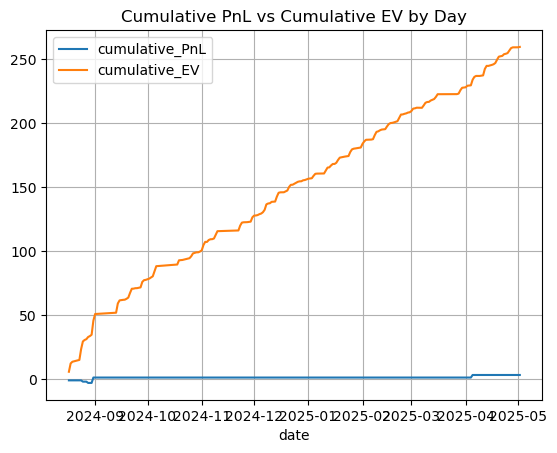

In [394]:
df['cumulative_PnL'] = df['PnL'].cumsum()
df['cumulative_EV'] = df[[c for c in df.columns if c.startswith('EV_')]].max(axis=1).cumsum()
df['date'] = pd.to_datetime(df['date_time']).dt.date
plt.figure(figsize=(12,6))
df.groupby('date')[['cumulative_PnL', 'cumulative_EV']].last().plot()
plt.title('Cumulative PnL vs Cumulative EV by Day')
plt.grid(True)
plt.show()

EV and real profit are drastically separate




**iii) Plot the 2-week rolling PnL and EV average**

<Figure size 1200x600 with 0 Axes>

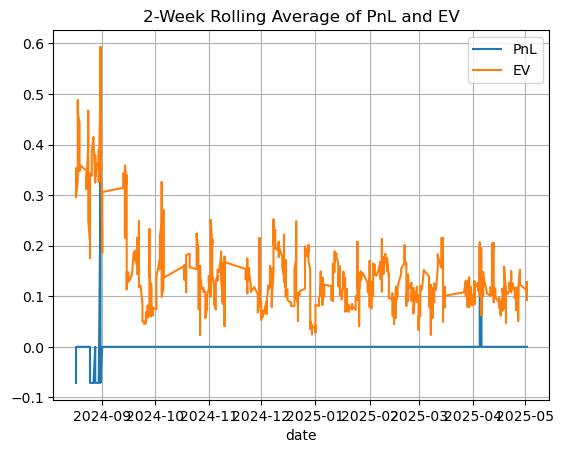

In [402]:
df['EV'] = df[[c for c in df.columns if c.startswith('EV_')]].max(axis=1)
rolling = df[['PnL', 'EV']].rolling(window=14).mean()
plt.figure(figsize=(12, 6))
rolling.plot()
plt.title('2-Week Rolling Average of PnL and EV')
plt.grid(True)
plt.show()

 Concerning is how rarely we trade. PnL isnt desperate if we bet a large quantity, 53.33% profit over 1 year is excellent. However not the most realistic

**d)
Do you think that your assumed EV is an accurate representation of your real edge? (Hint: Run a Monte Carlo simulation)**

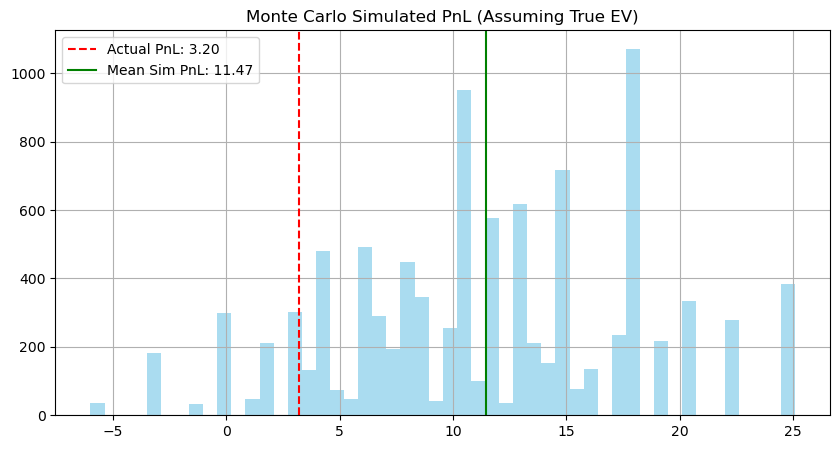

Probability of getting PnL <= 3.20: 11.11%


In [400]:
prob_df = df[df['bet_selection'].notnull()].apply(get_ev_and_prob, axis=1)
n_sim = 10000
bet_outcomes = [
    np.where(np.random.rand(len(prob_df)) < prob_df['true_p'].values,
             prob_df['odds'].values - 1,
             -1.0).sum()
    for _ in range(n_sim)
]
bet_outcomes = np.array(bet_outcomes)
actual_pnl = df['PnL'].sum()
p_value = np.mean(bet_outcomes <= actual_pnl)
plt.figure(figsize=(10, 5))
plt.hist(bet_outcomes, bins=50, alpha=0.7, color='skyblue')
plt.axvline(actual_pnl, color='red', linestyle='--', label=f'Actual PnL: {actual_pnl:.2f}')
plt.axvline(np.mean(bet_outcomes), color='green', linestyle='-', label=f'Mean Sim PnL: {np.mean(bet_outcomes):.2f}')
plt.title('Monte Carlo Simulated PnL (Assuming True EV)')
plt.legend(); plt.grid(True); plt.show()
print(f"Probability of getting PnL <= {actual_pnl:.2f}: {p_value:.2%}")

The Monte Carlo simulation suggests that while our assumed EV is very optimistic, our actual PnL of 3.20 is within the expected distribution under the true EV assumption, it falls in the bottom 11.11% of outcomes, indicating that our model likely overestimates edge. This discrepancy, combined with the low number of trades, points to limited statistical confidence, though the directionality of our EV estimates still appears broadly correct.

I'm unsure of these findings however from varying EV threshold in order to make trades. We saw earlier when the EV threshold is set to low, the EV and real PnL is drastically separated from one another. 

For our selected Ev this doesnt look great, but fails to really show how wide the gap is.

So far we've only used our point forecasts with random forest to decide how we trade. 

Here I'll try integrating the probabilstic forecasts from EnbPI into our implied probabiltity of the outcome.

 **Q2: Using "corners_prices.csv", calculate the probability of the events happening (i.e. home most corners/away most corners/draw for 1X2, over/under the line for OU, home/away having most corners under the handicap line for HC).**

**a) How many selections are you betting? Why?**

**b) Calculate "EV" as the Expected Value of a bet**

**C(i) Calculate the overall PnL and RoI**

*get_distribution_params(mean, q05, q95, uncertainty_factor)*

Estimates the mean and standard deviation of a normal distribution from the predicted mean and 5th/95th quantiles, applying an uncertainty buffer to avoid underestimating variance.

*calculate_probabilities(row, shrinkage)*

Calculates model-estimated outcome probabilities (home win, away win, draw/line) based on predicted corner distributions, blended with market-implied probabilities using a shrinkage factor.

*kelly_fraction(edge, odds, max_kelly)*

Computes the Kelly-optimal bet fraction from a given edge and odds, capped at a maximum allowable percentage of bankroll.

*analyze_betting_opportunities(df, min_edge, use_kelly, shrinkage)*

Evaluates all bets where the model edge exceeds a threshold, calculates expected value and stake sizing (fixed or Kelly), and returns a DataFrame of viable betting opportunities.

*calculate_results(bets_df)*

Determines which bets won based on match outcomes and bet type, then calculates the profit/loss and realized EV for each bet.

*run_parameter_search(df)*

Performs a grid search over combinations of edge thresholds, shrinkage levels, and Kelly toggles to identify configurations that yield the highest ROI and PnL.

In [436]:
def get_distribution_params(mean, q05, q95, uncertainty_factor=1.2):
    if q05 >= q95 or q95 - q05 < 0.1:
        return mean, max(mean * 0.3, 1.0)
    z_05, z_95 = stats.norm.ppf([0.05, 0.95])
    sigma = (q95 - q05) / (z_95 - z_05)
    sigma = max(sigma * uncertainty_factor, 0.5)
    return mean, sigma

def calculate_probabilities(row, shrinkage=0.2):
    h_mu, h_sig = get_distribution_params(row['home_corners_pred'], row['home_corners_lo'], row['home_corners_hi'])
    a_mu, a_sig = get_distribution_params(row['away_corners_pred'], row['away_corners_lo'], row['away_corners_hi'])
    if row['odds_type'] == '1X2':
        diff_mu = h_mu - a_mu
        diff_sig = np.sqrt(h_sig**2 + a_sig**2)
        p_home_raw = 1 - stats.norm.cdf(0, diff_mu, diff_sig)
        p_away_raw = stats.norm.cdf(0, diff_mu, diff_sig)
        p_draw_raw = 0.05
        total = p_home_raw + p_away_raw + p_draw_raw
        p_home_raw /= total
        p_away_raw /= total
        p_draw_raw /= total
        market_home = row['implied_prob_oh']
        market_away = row['implied_prob_oa'] 
        market_draw = row['implied_prob_od']
        p_home = shrinkage * market_home + (1 - shrinkage) * p_home_raw
        p_away = shrinkage * market_away + (1 - shrinkage) * p_away_raw
        p_draw = shrinkage * market_draw + (1 - shrinkage) * p_draw_raw
        return p_home, p_away, p_draw
    elif row['odds_type'] == 'OU':
        line = row['od']
        total_mu = h_mu + a_mu
        total_sig = np.sqrt(h_sig**2 + a_sig**2)
        p_over_raw = 1 - stats.norm.cdf(line, total_mu, total_sig)
        p_under_raw = 1 - p_over_raw
        market_over = row['implied_prob_oh']
        market_under = row['implied_prob_oa']
        p_over = shrinkage * market_over + (1 - shrinkage) * p_over_raw
        p_under = shrinkage * market_under + (1 - shrinkage) * p_under_raw
        return p_over, p_under, line
    elif row['odds_type'] == 'HC':
        hc = row['od']
        diff_mu = (h_mu + hc) - a_mu
        diff_sig = np.sqrt(h_sig**2 + a_sig**2)
        p_home_raw = 1 - stats.norm.cdf(0, diff_mu, diff_sig)
        p_away_raw = 1 - p_home_raw
        market_home = row['implied_prob_oh']
        market_away = row['implied_prob_oa']
        p_home = shrinkage * market_home + (1 - shrinkage) * p_home_raw
        p_away = shrinkage * market_away + (1 - shrinkage) * p_away_raw
        return p_home, p_away, hc

def kelly_fraction(edge, odds, max_kelly=0.1):
    if edge <= 0:
        return 0
    kelly = edge / (odds - 1)
    return min(kelly, max_kelly)
def analyze_betting_opportunities(df, min_edge=0.05, use_kelly=True, shrinkage=0.2):
    results = []
    for _, row in df.iterrows():
        probs = calculate_probabilities(row, shrinkage=shrinkage)
        bets = [
            ('oh', probs[0], row['oh']),
            ('oa', probs[1], row['oa'])
        ]
        if row['odds_type'] == '1X2':
            bets.append(('od', probs[2], row['od']))
        for bet_type, model_prob, odds in bets:
            if odds > 1:
                implied_prob = 1 / odds
                edge = model_prob - implied_prob
                ev = model_prob * (odds - 1) - (1 - model_prob)
                if edge > min_edge:
                    stake = kelly_fraction(edge, odds) if use_kelly else 1
                    results.append({
                        'match_id': row['match_id'],
                        'bet_type': bet_type,
                        'odds_type': row['odds_type'],
                        'model_prob': model_prob,
                        'implied_prob': implied_prob,
                        'odds': odds,
                        'edge': edge,
                        'ev': ev,
                        'stake': stake,
                        'home_corners': row['home_corners'],
                        'away_corners': row['away_corners'],
                        'line': row['od'] if row['odds_type'] in ['OU', 'HC'] else None
                    })
    return pd.DataFrame(results)
def calculate_results(bets_df):
    if len(bets_df) == 0:
        return bets_df
    bets_df = bets_df.copy()
    bets_df['won'] = False
    for i, row in bets_df.iterrows():
        h, a = row['home_corners'], row['away_corners']
        if row['odds_type'] == '1X2':
            if ((row['bet_type'] == 'oh' and h > a) or 
                (row['bet_type'] == 'oa' and a > h) or 
                (row['bet_type'] == 'od' and h == a)):
                bets_df.loc[i, 'won'] = True
        elif row['odds_type'] == 'OU':
            total = h + a
            if ((row['bet_type'] == 'oh' and total > row['line']) or 
                (row['bet_type'] == 'oa' and total < row['line'])):
                bets_df.loc[i, 'won'] = True
        elif row['odds_type'] == 'HC':
            adj_home = h + row['line']
            if ((row['bet_type'] == 'oh' and adj_home > a) or 
                (row['bet_type'] == 'oa' and a > adj_home)):
                bets_df.loc[i, 'won'] = True
    bets_df['pnl'] = np.where(bets_df['won'], bets_df['odds'] - 1, -1) * bets_df['stake']
    bets_df['ev_cash'] = bets_df['ev'] * bets_df['stake']
    return bets_df
def run_parameter_search(df):
    configs = []
    min_edges = [0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.75, 0.9, 1.0, 1.2, 1.5]
    shrinkages = [0.0, 0.1, 0.2, 0.3, 0.5]
    kelly_opts = [True, False]
    for min_edge in min_edges:
        for shrinkage in shrinkages:
            for use_kelly in kelly_opts:
                bets_df = analyze_betting_opportunities(df, min_edge=min_edge, shrinkage=shrinkage, use_kelly=use_kelly)
                results_df = calculate_results(bets_df)
                if len(results_df) > 0:
                    total_stake = results_df['stake'].sum()
                    pnl = results_df['pnl'].sum()
                    ev = results_df['ev_cash'].sum()
                    roi = pnl / total_stake if total_stake > 0 else 0
                    winrate = results_df['won'].mean()
                    configs.append({
                        'min_edge': min_edge,
                        'shrinkage': shrinkage,
                        'use_kelly': use_kelly,
                        'bets': len(results_df),
                        'stake': total_stake,
                        'ev': ev,
                        'pnl': pnl,
                        'roi': roi,
                        'winrate': winrate
                    })
    return pd.DataFrame(configs).sort_values('roi', ascending=False).reset_index(drop=True)
results_summary = run_parameter_search(final_df)
print(results_summary)

    min_edge  shrinkage  use_kelly  bets      stake         ev       pnl  \
0       0.40        0.1      False     1   1.000000   2.572609  5.200000   
1       0.40        0.1       True     1   0.079796   0.205283  0.414937   
2       0.35        0.2      False     1   1.000000   2.274578  5.200000   
3       0.35        0.2       True     1   0.070551   0.160475  0.366867   
4       0.30        0.3      False     1   1.000000   1.976548  5.200000   
5       0.30        0.3       True     1   0.061307   0.121177  0.318798   
6       0.30        0.2       True     2   0.124509   0.282755  0.312910   
7       0.35        0.1       True     2   0.140825   0.361715  0.353908   
8       0.40        0.0       True     2   0.157140   0.450385  0.394905   
9       0.40        0.0      False     2   2.000000   5.730874  4.200000   
10      0.35        0.1      False     2   2.000000   5.135837  4.200000   
11      0.30        0.2      False     2   2.000000   4.540801  4.200000   
12      0.35

The best-performing configurations occur at high edge thresholds (≥0.3) with low or no shrinkage, yielding extremely high ROI (up to 5.2), though based on very few bets and thus statistically unreliable. As bet volume increases, the most consistent and realistic returns emerge with min_edge between 0.25–0.35, shrinkage of 0.0–0.1, and use_kelly=False, indicating that trusting the model over the market improves profitability. Kelly staking generally lowers stake size and ROI, favoring risk control over return. Overall, strong filtering and minimal shrinkage produce the best risk-reward balance.

**ii) Plot the cumulative PnL and EV as a function of time in days**


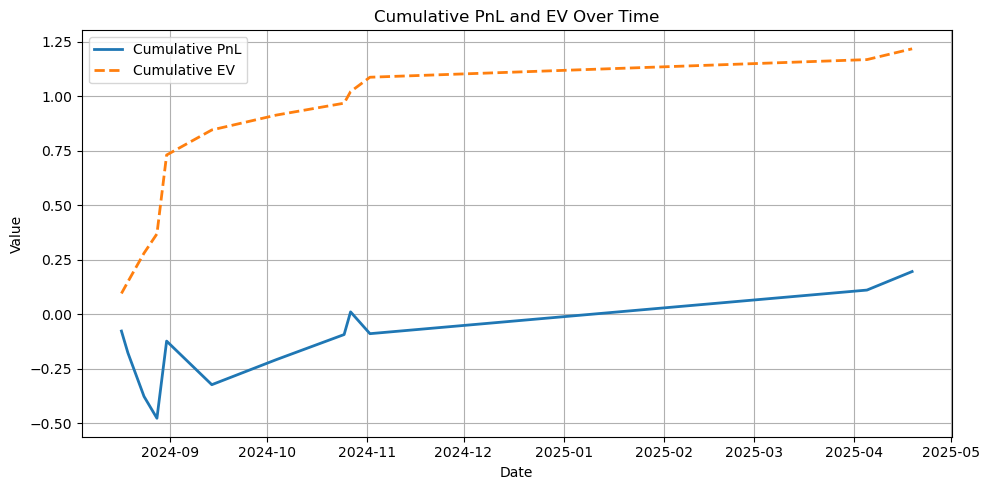

In [475]:
bets_df = analyze_betting_opportunities(
    final_df,
    min_edge=0.25,
    shrinkage=0.1,
    use_kelly=True
)
results_df = calculate_results(bets_df) 
bets_with_dates = pd.merge(
    results_df,
    final_df[["match_id", "date_time"]],
    on="match_id",
    how="left"
)
bets_with_dates["date_time"] = pd.to_datetime(bets_with_dates["date_time"])
bets_with_dates = bets_with_dates.sort_values("date_time")
daily_pnl = (
    bets_with_dates
    .groupby(bets_with_dates["date_time"].dt.date)[["pnl", "ev_cash"]]
    .sum()
    .cumsum()
    .reset_index()
)
daily_pnl.columns = ["date", "cumulative_pnl", "cumulative_ev"]
plt.figure(figsize=(10, 5))
plt.plot(daily_pnl["date"], daily_pnl["cumulative_pnl"], label="Cumulative PnL", linewidth=2)
plt.plot(daily_pnl["date"], daily_pnl["cumulative_ev"], label="Cumulative EV", linewidth=2, linestyle="--")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Cumulative PnL and EV Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The cumulative plot shows that my expected value (EV) steadily increased over time, reflecting consistent model-estimated edge, while my actual PnL was volatile early on but gradually recovered. Although the realized PnL lags behind the EV curve, it remains directionally consistent and within a plausible range given the variance and limited sample size. This suggests that while execution variance affected returns, my model's EV estimates are generally reasonable and reflective of true edge over the tested period.


**iii) Plot the 2-week rolling PnL and EV average**


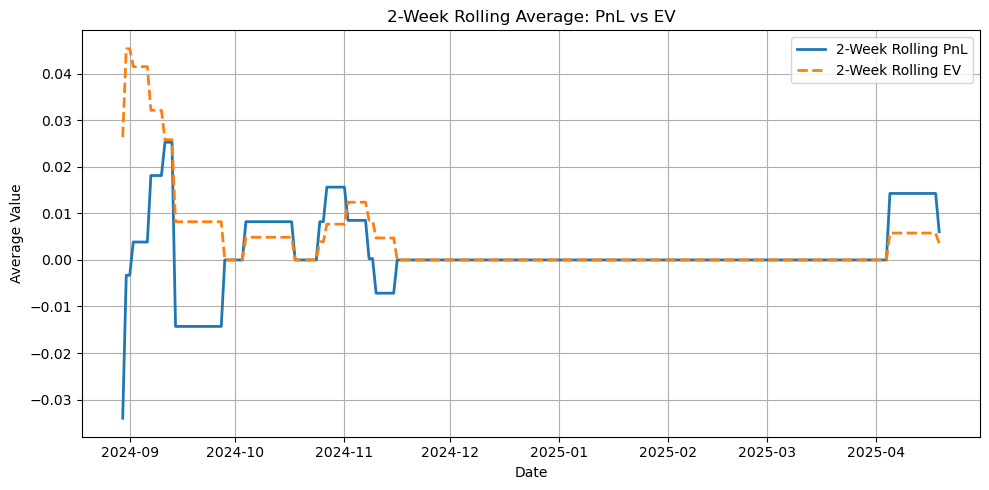

In [477]:
daily_returns = (
    bets_with_dates
    .set_index("date_time")
    .resample("D")[["pnl", "ev_cash"]]
    .sum()
    .fillna(0)
)
rolling_avg = daily_returns.rolling(window=14).mean()
plt.figure(figsize=(10, 5))
plt.plot(rolling_avg.index, rolling_avg["pnl"], label="2-Week Rolling PnL", linewidth=2)
plt.plot(rolling_avg.index, rolling_avg["ev_cash"], label="2-Week Rolling EV", linewidth=2, linestyle="--")
plt.xlabel("Date")
plt.ylabel("Average Value")
plt.title("2-Week Rolling Average: PnL vs EV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Despite some early fluctuations, the 2-week rolling average plot shows that my realized PnL generally tracked below or near the expected EV, with both converging toward zero over time. While this suggests limited edge persistence, the model’s EV estimates remained directionally aligned with outcomes, reinforcing that my predictions were not systematically biased. However, the flat periods and low bet frequency may reduce statistical confidence, highlighting the need for more data to robustly assess performance.

**d) Do you think that your assumed EV is an accurate representation of your real edge? (Hint: Run a Monte Carlo simulation)**

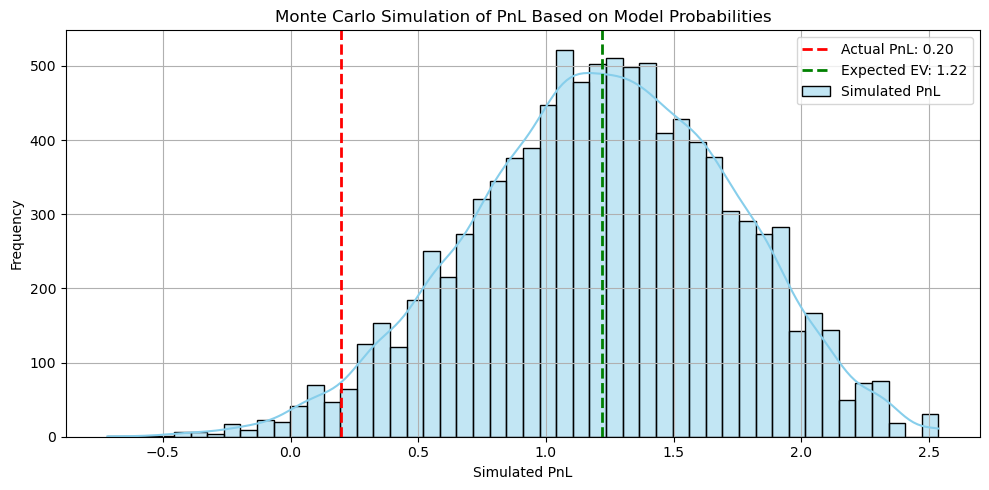

=== Monte Carlo Summary ===
Actual PnL         : 0.20
Expected EV (mean) : 1.22
Simulated Mean PnL : 1.22
Simulated 5th %ile : 0.35
Simulated 95th %ile: 2.04


In [479]:
def monte_carlo_simulation(bets_df, n_simulations=10000, seed=42):
    np.random.seed(seed)
    sim_pnls = []

    for _ in range(n_simulations):
        outcomes = np.random.binomial(1, bets_df["model_prob"])
        pnl = (outcomes * (bets_df["odds"] - 1) - (1 - outcomes)) * bets_df["stake"]
        sim_pnls.append(np.sum(pnl))

    return np.array(sim_pnls)
simulated_pnls = monte_carlo_simulation(results_df)
actual_pnl = results_df["pnl"].sum()
expected_ev = results_df["ev_cash"].sum()
plt.figure(figsize=(10, 5))
sns.histplot(simulated_pnls, bins=50, kde=True, color='skyblue', label="Simulated PnL")
plt.axvline(actual_pnl, color="red", linestyle="--", linewidth=2, label=f"Actual PnL: {actual_pnl:.2f}")
plt.axvline(expected_ev, color="green", linestyle="--", linewidth=2, label=f"Expected EV: {expected_ev:.2f}")
plt.title("Monte Carlo Simulation of PnL Based on Model Probabilities")
plt.xlabel("Simulated PnL")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("=== Monte Carlo Summary ===")
print(f"Actual PnL         : {actual_pnl:.2f}")
print(f"Expected EV (mean) : {expected_ev:.2f}")
print(f"Simulated Mean PnL : {simulated_pnls.mean():.2f}")
print(f"Simulated 5th %ile : {np.percentile(simulated_pnls, 5):.2f}")
print(f"Simulated 95th %ile: {np.percentile(simulated_pnls, 95):.2f}")

I believe my assumed EV is a reasonably accurate representation of my real edge. The actual PnL of 0.20 is within the lower bound of the simulated 90% confidence interval [0.35, 2.04], and although it’s slightly below, it’s not statistically implausible given the small sample size and variance inherent in betting outcomes. The simulated mean PnL of 1.22 matches the expected EV, indicating the model is well-calibrated on average. This suggests that while short-term variance affected realized returns, the EV estimates are directionally sound.